# Data Pre-processing

First we'll load some packages and utility scripts

In [58]:
source('./processing_scripts/util.R')
tag="MCF10A"
library('ggplot2')
library('data.table')
library('cowplot')
options(warn=-1) # turn off warnings

and then read in the data

In [5]:
dm=15
ddir = './processed_data/'%+%tag%+%"/csv/"
dir(ddir)
d = read.csv(ddir%+%tag%+%"_"%+%dm%+%"_df.csv",row.names=1)
d = data.table(d)
d$PlateWell <- d$Plate%+%"."%+%d$Well

[1] "MCF10A_15_df.csv"       "MCF10A_15_features.csv" "MCF10A_5_df.csv"       
[4] "MCF10A_5_features.csv"

We also add in the feature "PlateWell" which is the interaction of Plate and Well. The variable `dm` is the number of dimensions of unwanted variation to remove. For this example we set it to 15. In this representation of the data there are 128064 rows (192 wells x 667 spots) and 486 columns (features)

In [60]:
dim(d)

[1] 128064    486

The first several features are meta data concerning the spots

In [61]:
head(colnames(d),n=20)

[1] "WellIndex"         "ArrayRow"          "ArrayColumn"      
 [4] "Barcode"           "Well"              "Spot"             
 [7] "PinDiameter"       "CellLineSet"       "CellLine"         
[10] "CellLineLx"        "CellLineAn"        "CellLineConc"     
[13] "CellLineConcUnit"  "CellLineTimeReact" "CellLineTimeUnit" 
[16] "ECMSet"            "ECM1"              "ECM1Lx"           
[19] "ECM1An"            "ECM1Conc"

and for each of the measured features there are three versions:
1. the raw version, 
2. the RR transformed version,
3. the adjusted RR version

In [62]:
colnames(d)[c(99,282,398)] # 3 versions of Nuclei Area

[1] "Nuclei_CP_AreaShape_Area"        "Nuclei_CP_AreaShape_Area_RR"    
[3] "Nuclei_CP_AreaShape_Area_RR_ADJ"

Before we do anything, we're going to center the features in the wells to account for that source of variation. We do this because our normalization approach will account for this and since its easy to account for we want to make sure we are doing a fair comparison with no normalization. we'll also create vectors of the numeric, texture, and non-texture numeric features.

In [63]:
numeric_cols = colnames(d)[71:ncol(d)-3][-(180:184)]
numeric_cols = numeric_cols[which(sapply(numeric_cols,function(s)grepl("_RR$|_RR_ADJ$",s)))]
texture_cols = numeric_cols[grepl("Texture",numeric_cols)]
non_texture = setdiff(numeric_cols,texture_cols)                                         
                                         
d = d[ , (numeric_cols) := lapply(.SD, function(x)x-mean(x,na.rm=TRUE)), .SDcols = numeric_cols,by=.(PlateWell)]

As a gut-check we'll just examine box-plots of cell count for the untouched, RR, and RR + adjustment versions

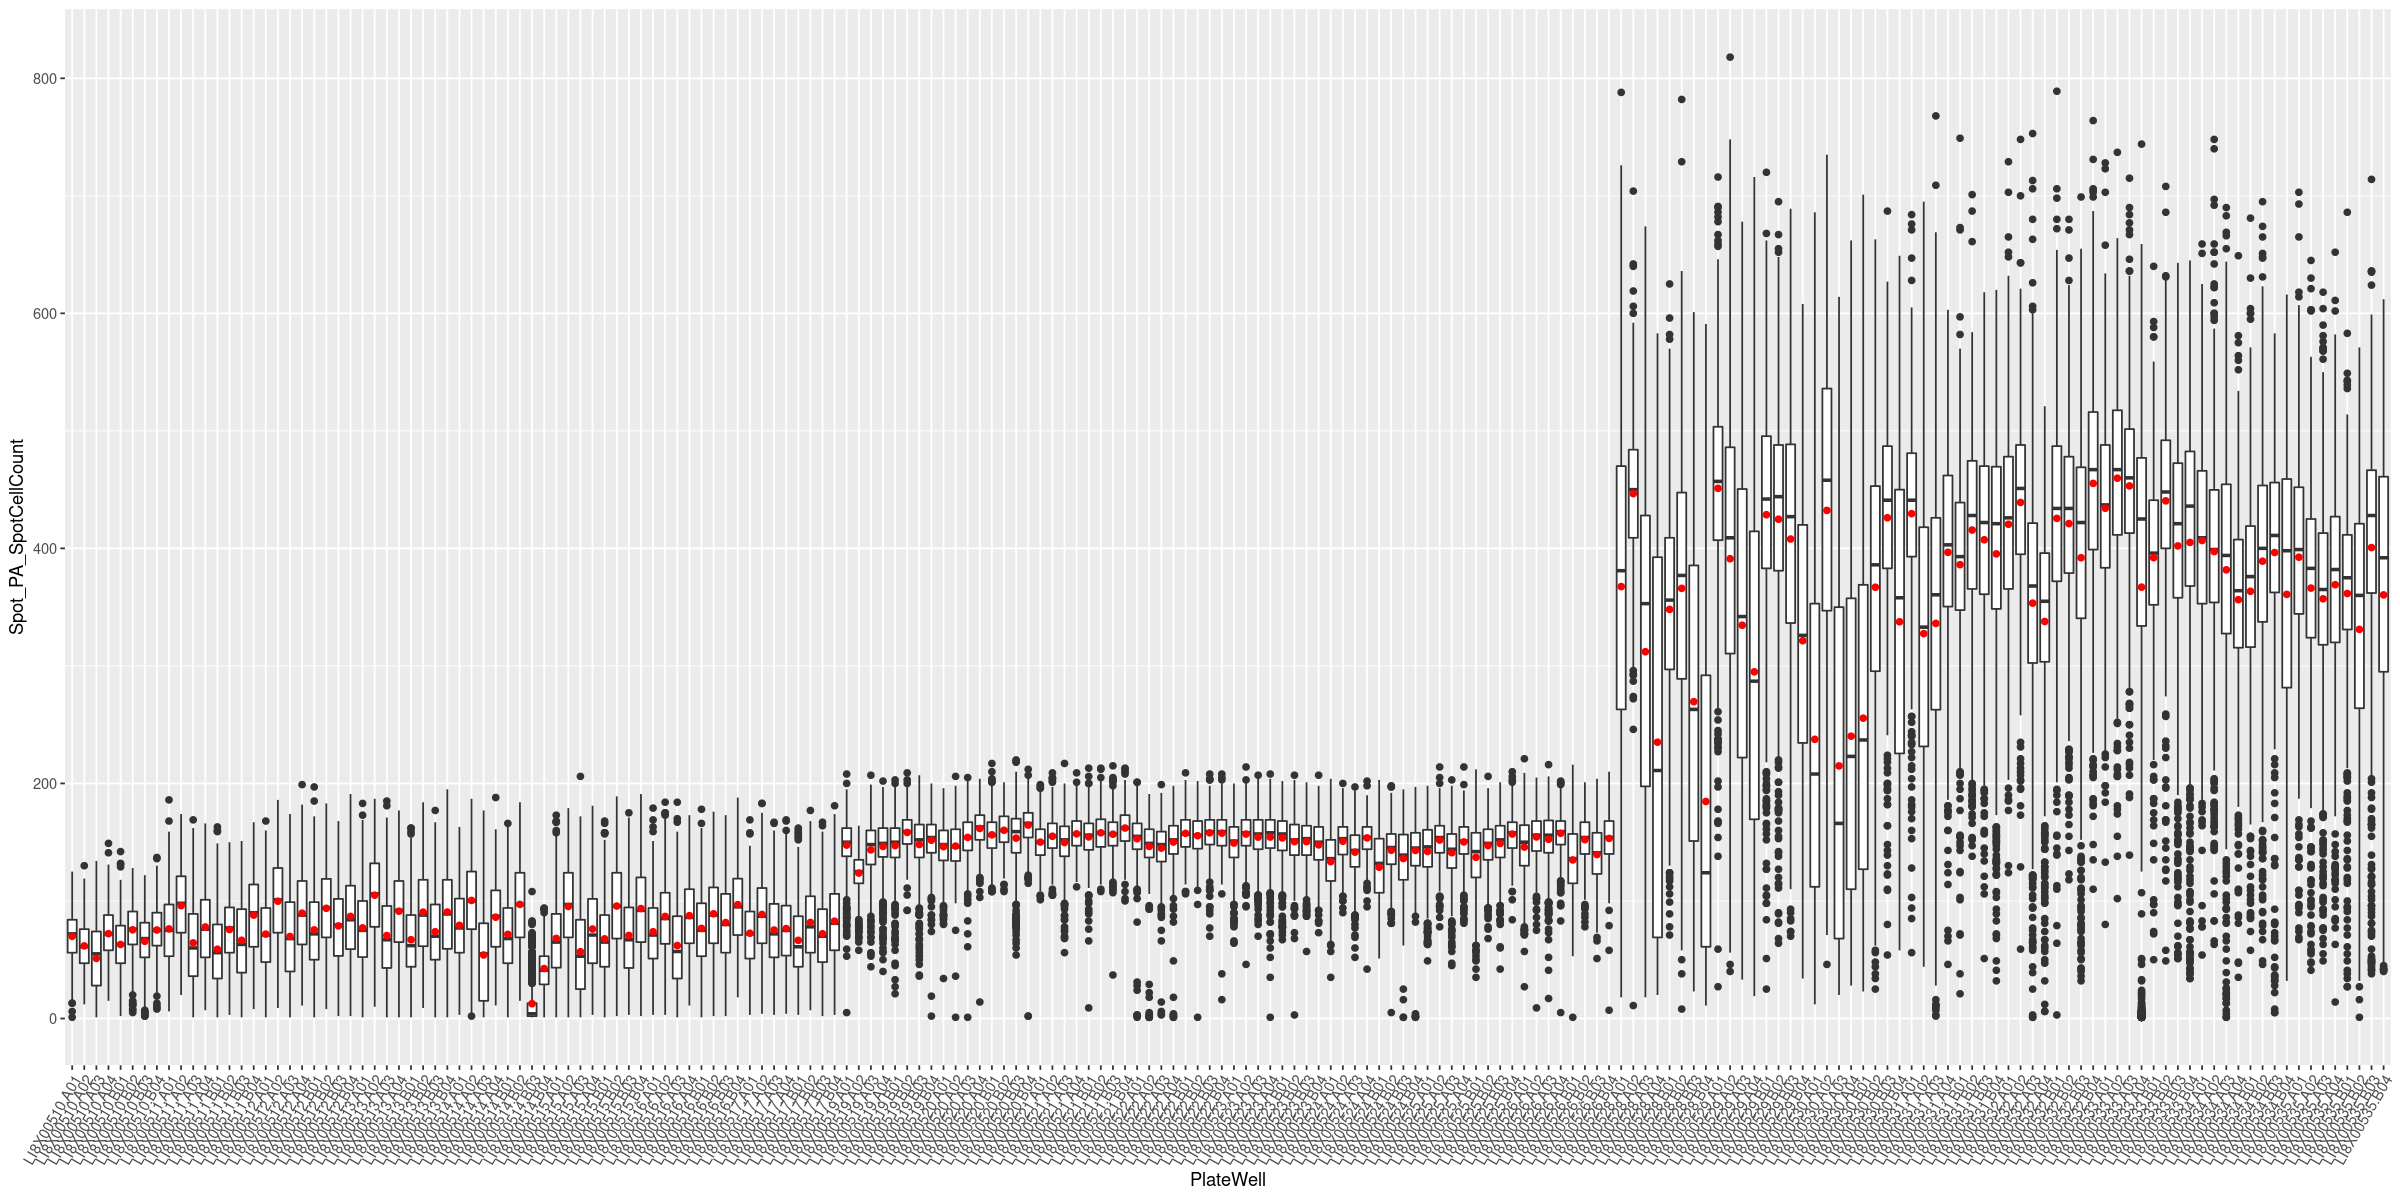

In [64]:
ft = "Spot_PA_SpotCellCount"
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(data=d,mapping=aes_string(x="PlateWell",y=ft))+geom_boxplot()+
    stat_summary(fun.y=mean,geom="point",col='red')+
    theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))

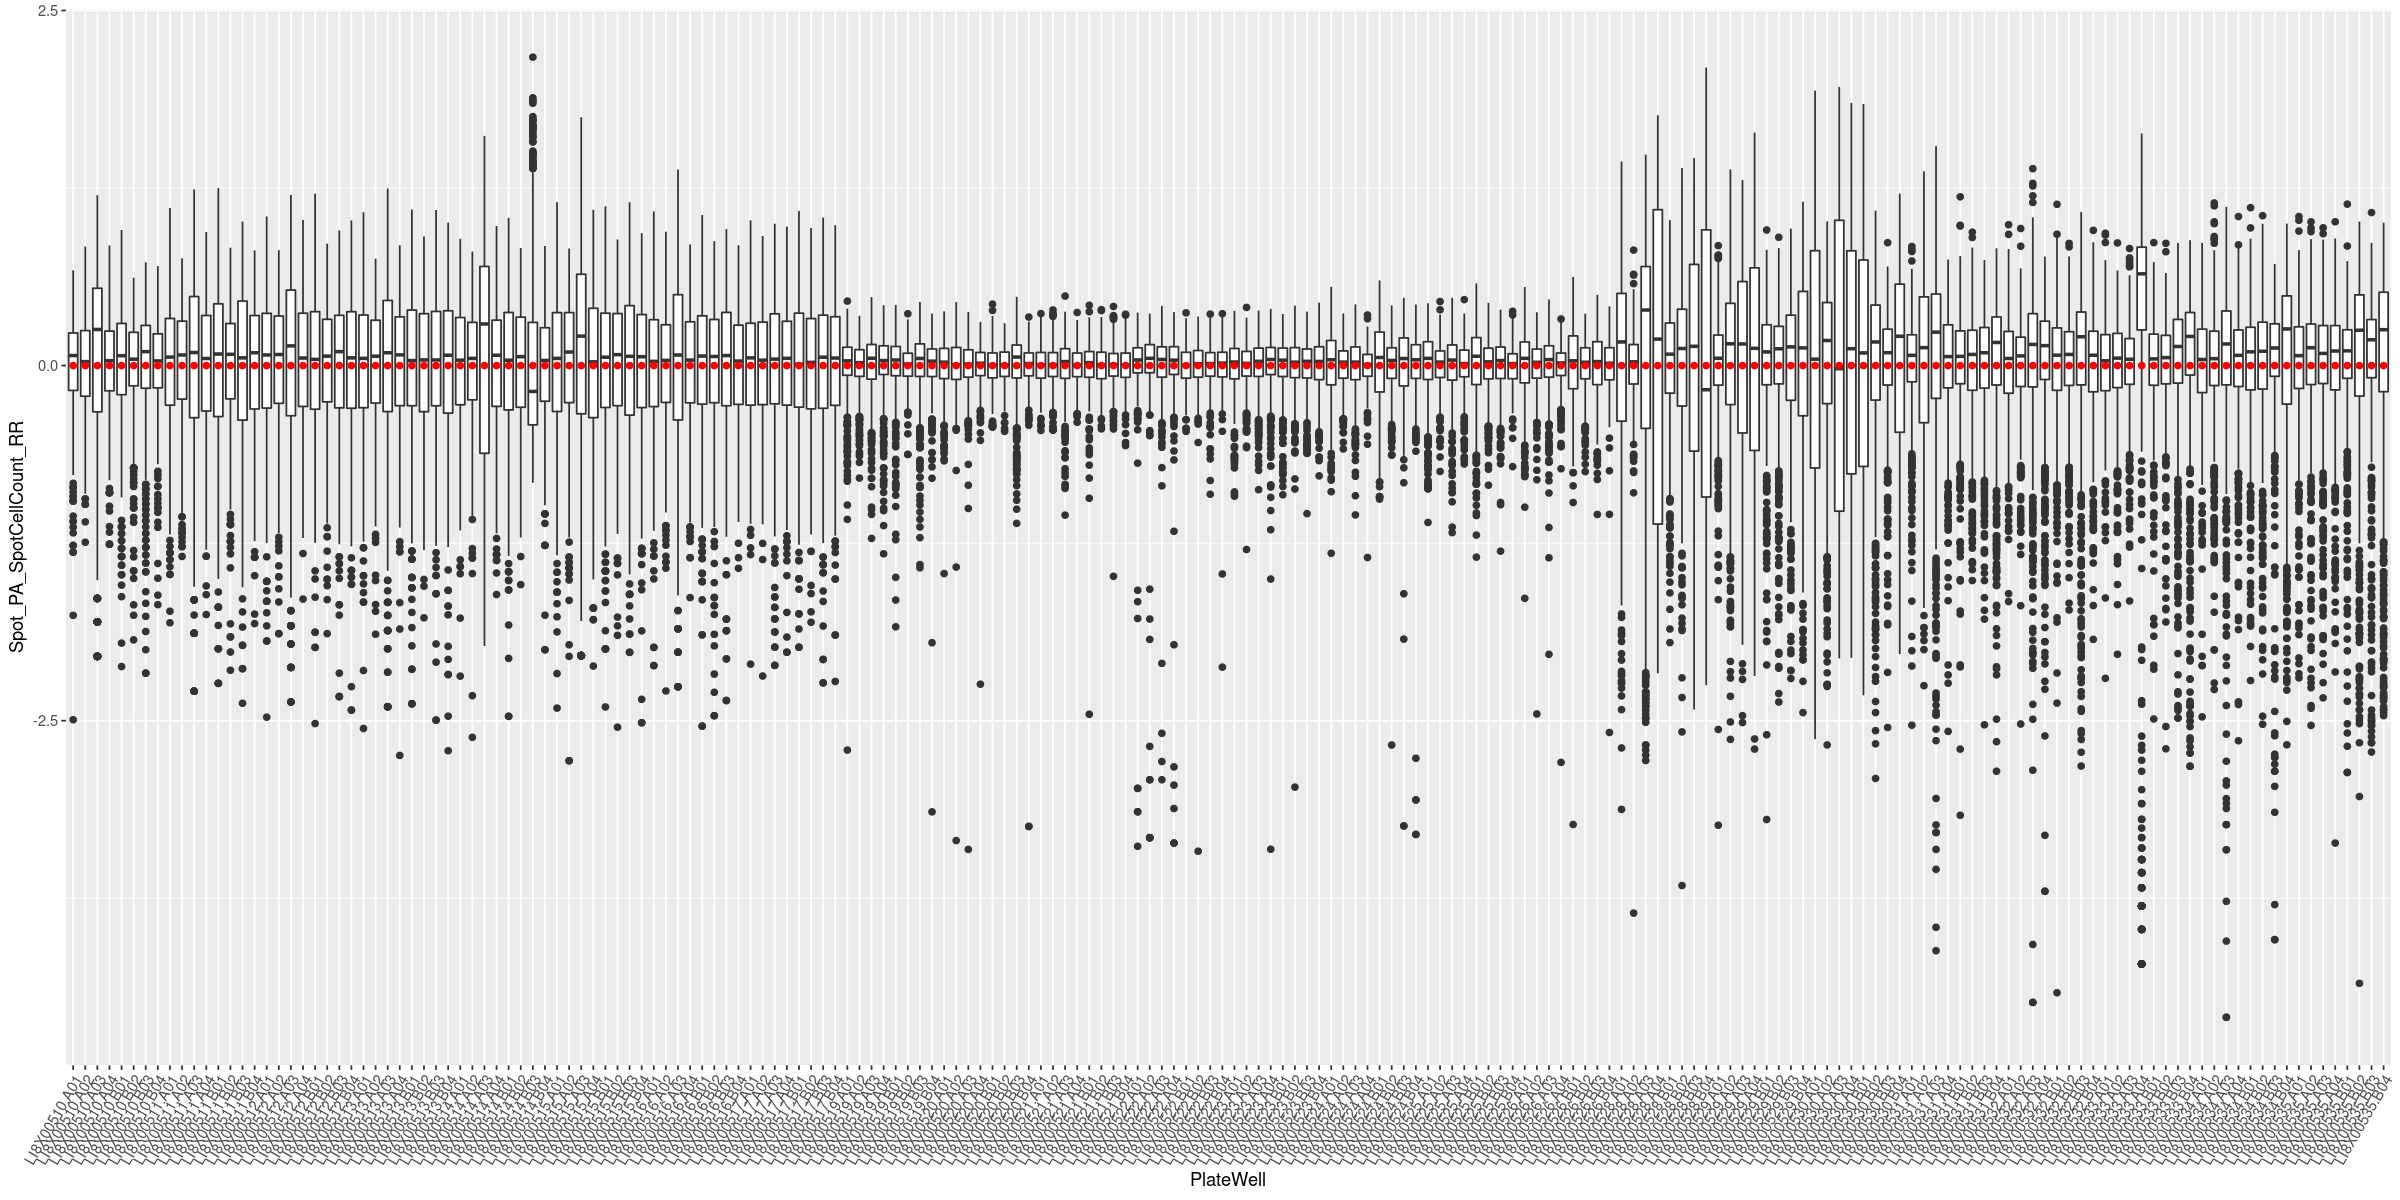

In [65]:
ft = "Spot_PA_SpotCellCount_RR"
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(data=d,mapping=aes_string(x="PlateWell",y=ft))+geom_boxplot()+
    stat_summary(fun.y=mean,geom="point",col='red')+
    theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))

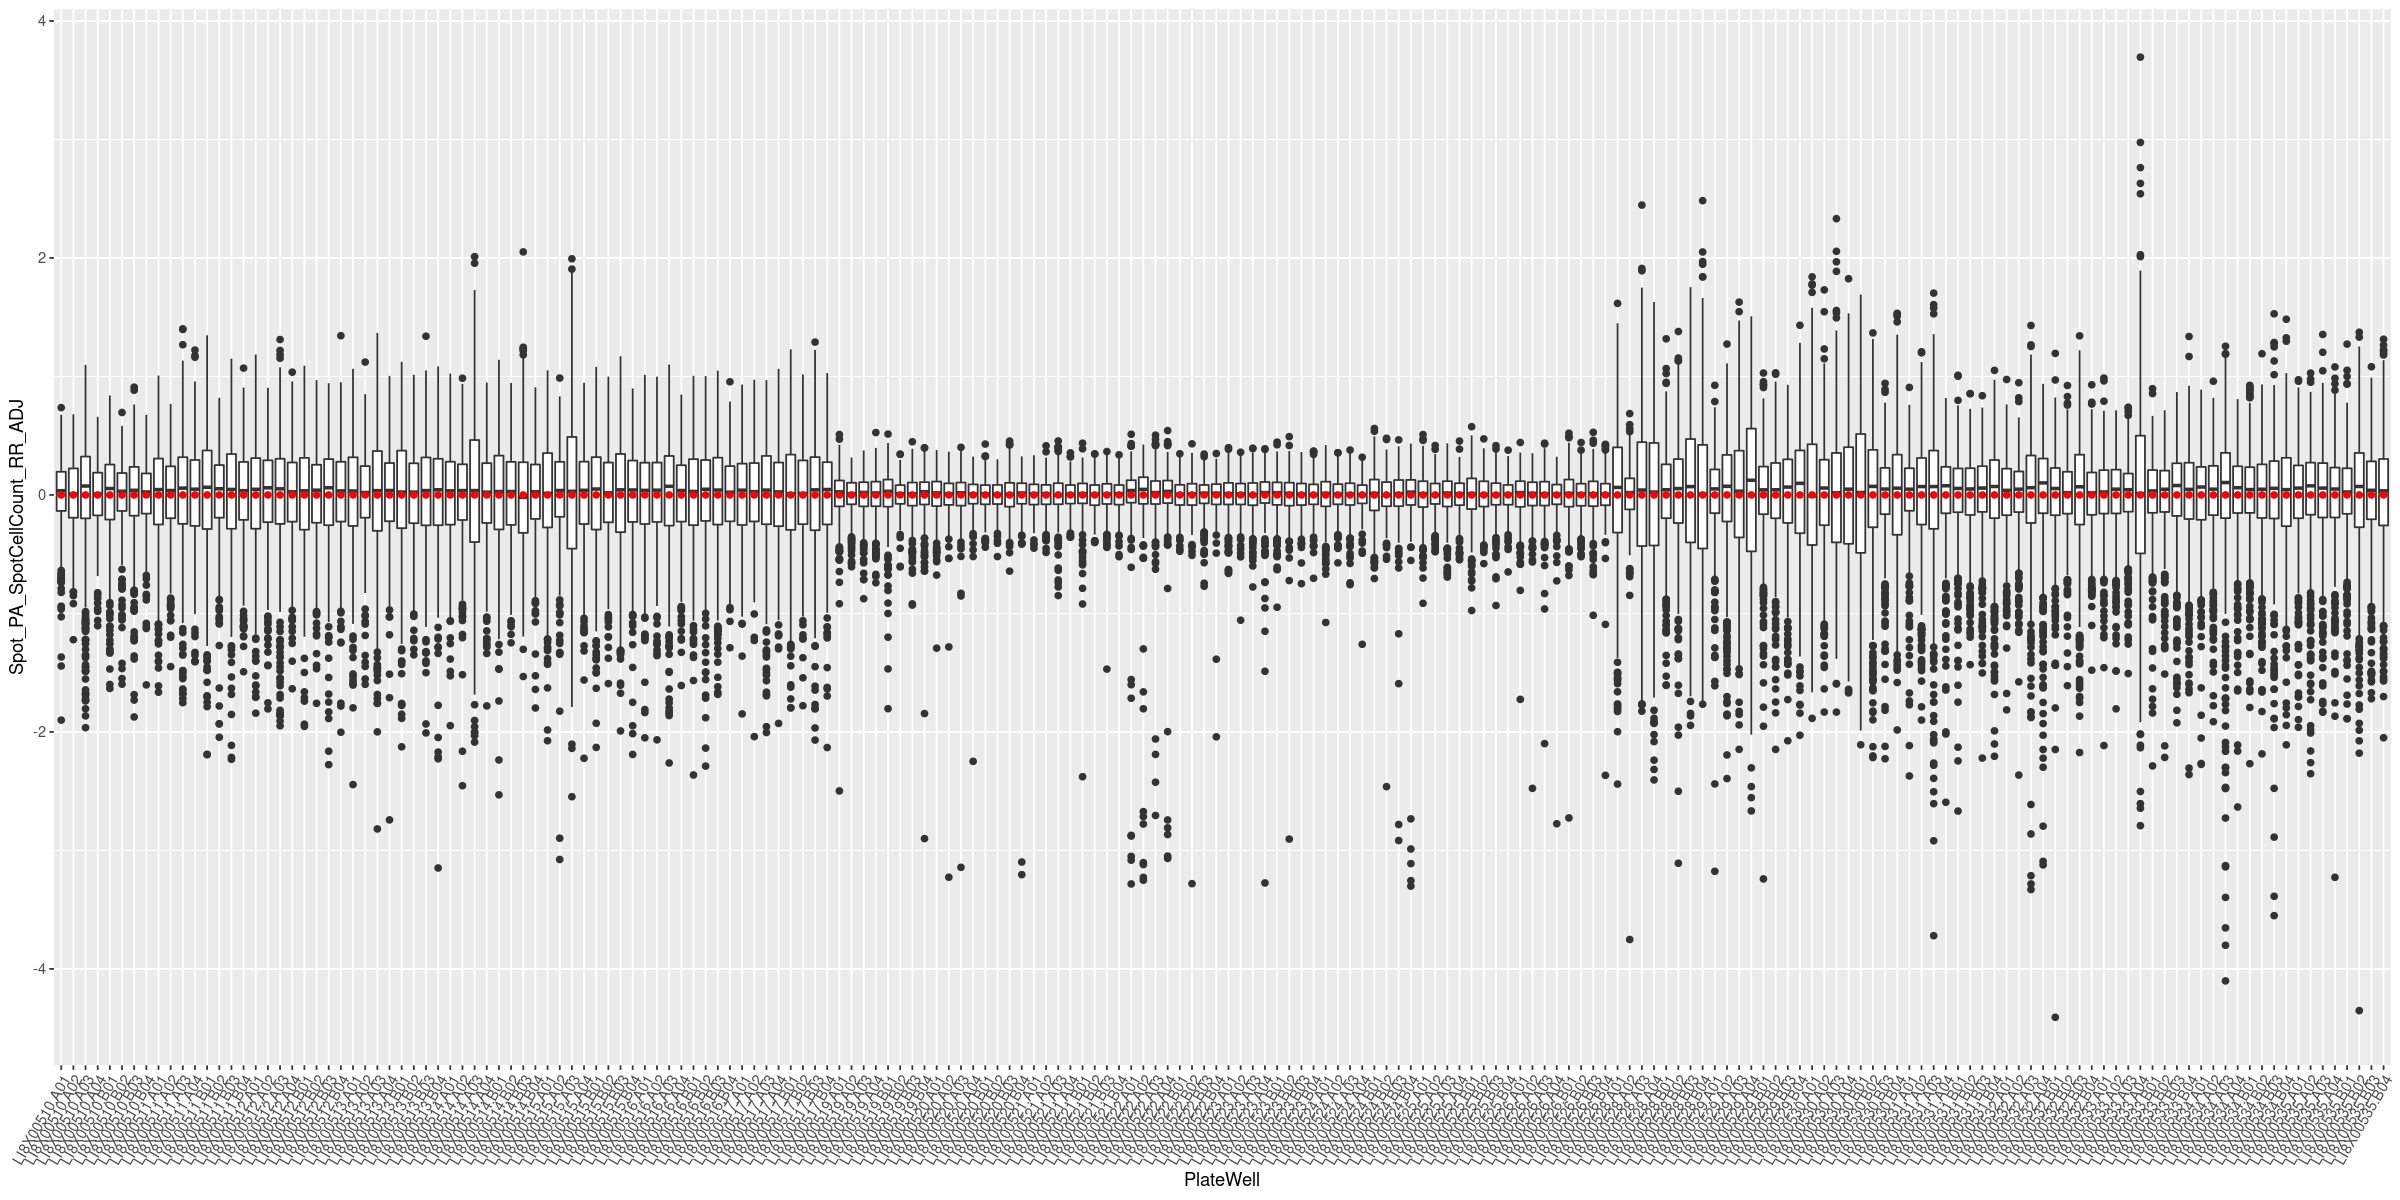

In [66]:
ft = "Spot_PA_SpotCellCount_RR_ADJ"
ggplot(data=d,mapping=aes_string(x="PlateWell",y=ft))+geom_boxplot()+
    stat_summary(fun.y=mean,geom="point",col='red')+
    theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))

In addition to the format of the .csv file it will be useful to have a list of feature matrices. For each matrix a row is a well and each column a spot.

In [14]:
source('./processing_scripts/make_fmat.R')
fmats = lapply(names(d),function(v)make_fmat(d,v))
names(fmats) <- names(d)

For this data we have three staining batches we'll call 1, 2 and 3. We want to take note of which features are measured in which batch, here "1", "2", or "3" means the feature is measured in those batches alone, "13" means the feature is measured in batch 1 and 3, and "123" means it is measured in all batches. Those features measured in all batches were used to adjust the other features. 

In [67]:
staining_set = substr(apply(fmats$StainingSet,1,unique),3,3)
missing_rows = sapply(fmats,function(X)apply(X,1,function(x)all(is.na(x))))
feature_batch = apply(missing_rows,2,function(x)paste0(sort(unique(staining_set[!x])),collapse=""))
head(sample(feature_batch))

Cells_CP_AreaShape_Perimeter 
                                            "13" 
         Nuclei_CP_AreaShape_MinFeretDiameter_RR 
                                           "123" 
                               Spot_PA_Perimeter 
                                           "123" 
                           Spot_PA_SpotCellCount 
                                           "123" 
                                       ClarionID 
                                           "123" 
Nuclei_CP_Intensity_MedianIntensity_KRT19_RR_ADJ 
                                             "3"

For this dataset features are measured in either batches 1, 2, or 3 alone, batches 1 and 3, or all three batches. Note here a missing "feature batch" indicates meta-data.

In [68]:
print(unique(feature_batch))

[1] "123" ""    "13"  "3"   "1"   "2"  


# Plots

## 1 . Spatial shared across features (same well)

We want to show that the same spatial patterns appear across different features. 

### Example 1.1

In [69]:
source('./plot_scripts/plot_fns.R')
options(repr.plot.width = 10, repr.plot.height = 5)

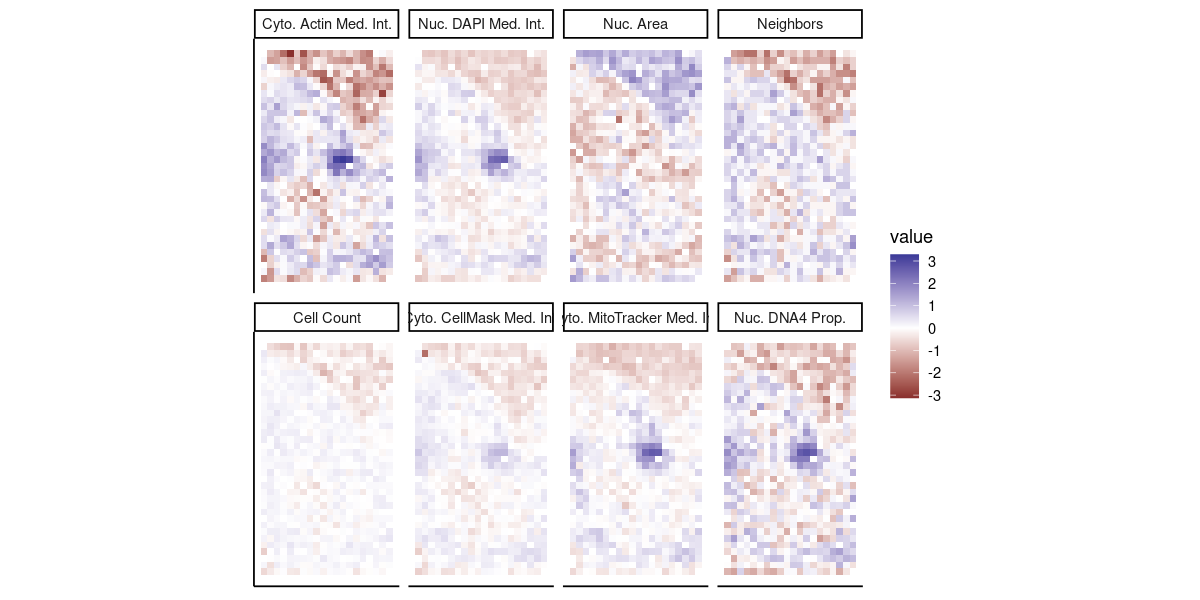

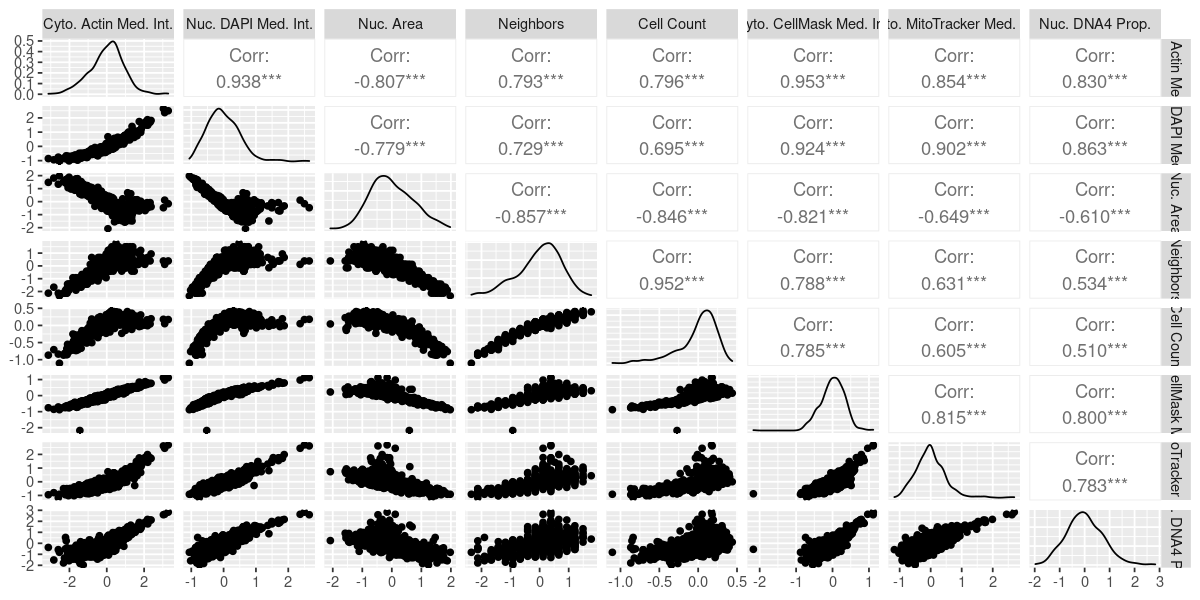

In [70]:
warn = getOption("warn")
options(warn=-1)


sel_feats = c('Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR',
                         'Nuclei_CP_Intensity_MedianIntensity_Dapi_RR',
                         'Nuclei_CP_AreaShape_Area_RR',
                         'Nuclei_PA_AreaShape_Neighbors_RR',
                         'Spot_PA_SpotCellCount_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_CellMask_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR',
                        'Nuclei_PA_Cycle_DNA4NProportion_RR')
short_names = c("Cyto. Actin Med. Int.",
               "Nuc. DAPI Med. Int.",
               "Nuc. Area",
               "Neighbors",
               "Cell Count",
               "Cyto. CellMask Med. Int.",
               "Cyto. MitoTracker Med. Int.",
               "Nuc. DNA4 Prop."
              )
sel_pw = "LI8X00525.A01"

wp1=well_plot(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw,
    facet="~Feature")

ws1=well_scatter(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw)

wp1
ws1

options(warn=warn)

### Example 1.2

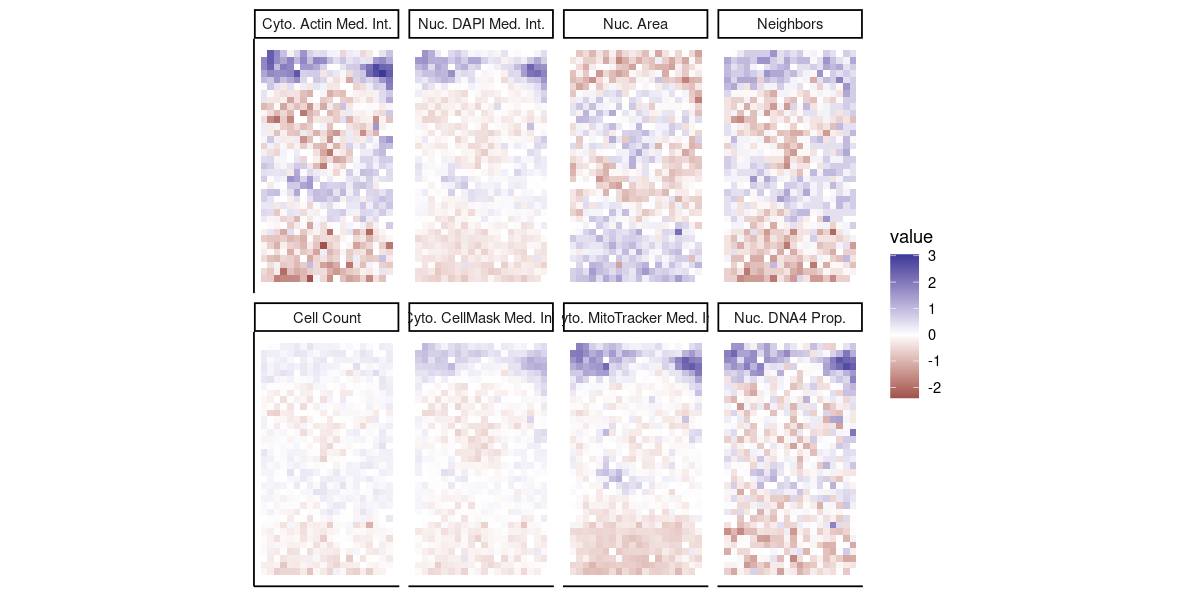

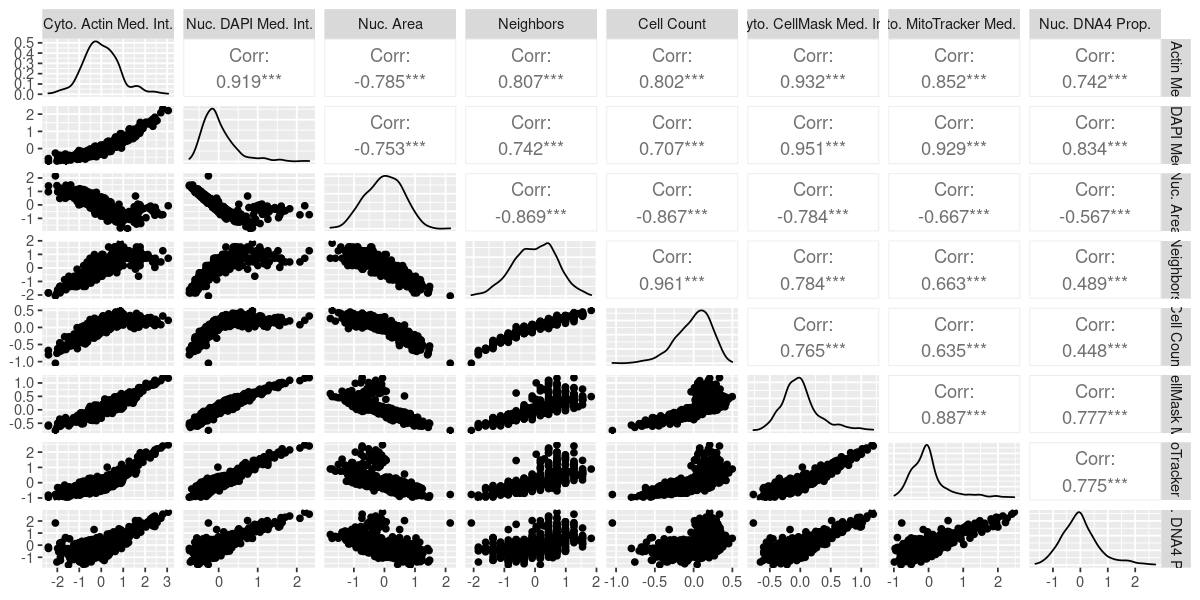

In [71]:
warn = getOption("warn")
options(warn=-1)

sel_feats=c('Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR',
                         'Nuclei_CP_Intensity_MedianIntensity_Dapi_RR',
                         'Nuclei_CP_AreaShape_Area_RR',
                         'Nuclei_PA_AreaShape_Neighbors_RR',
                         'Spot_PA_SpotCellCount_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_CellMask_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR',
                        'Nuclei_PA_Cycle_DNA4NProportion_RR')
short_names = c("Cyto. Actin Med. Int.",
               "Nuc. DAPI Med. Int.",
               "Nuc. Area",
               "Neighbors",
               "Cell Count",
               "Cyto. CellMask Med. Int.",
               "Cyto. MitoTracker Med. Int.",
               "Nuc. DNA4 Prop."
              )
sel_pw="LI8X00526.B03"

wp2=well_plot(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw,
    facet="~Feature")

ws2=well_scatter(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw)

wp2
ws2

options(warn=warn)

### Example 1.3

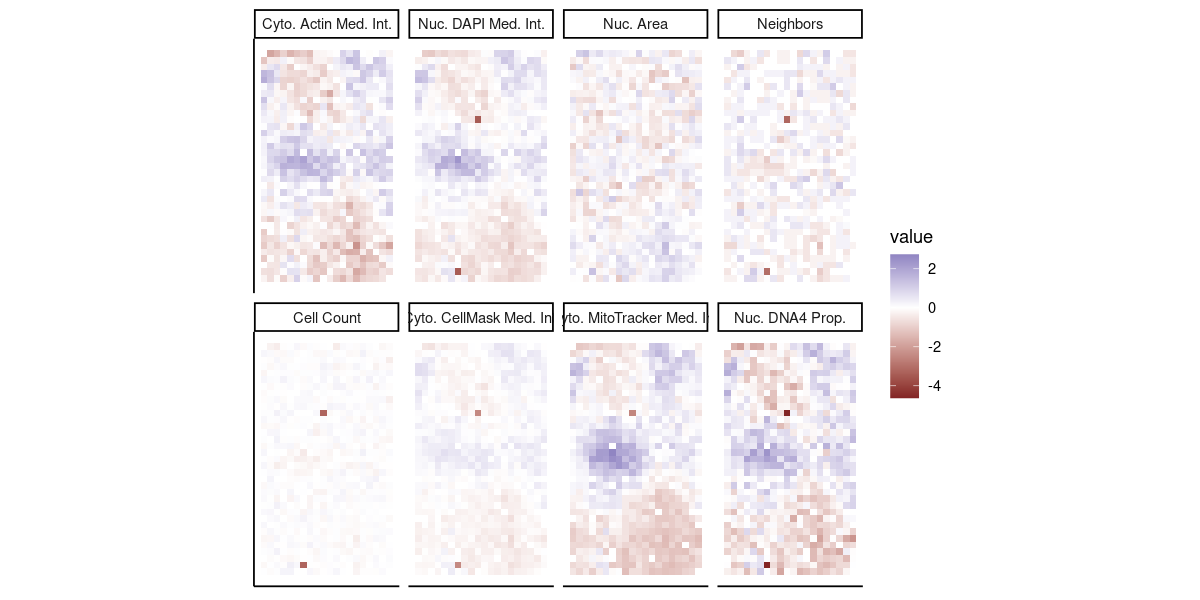

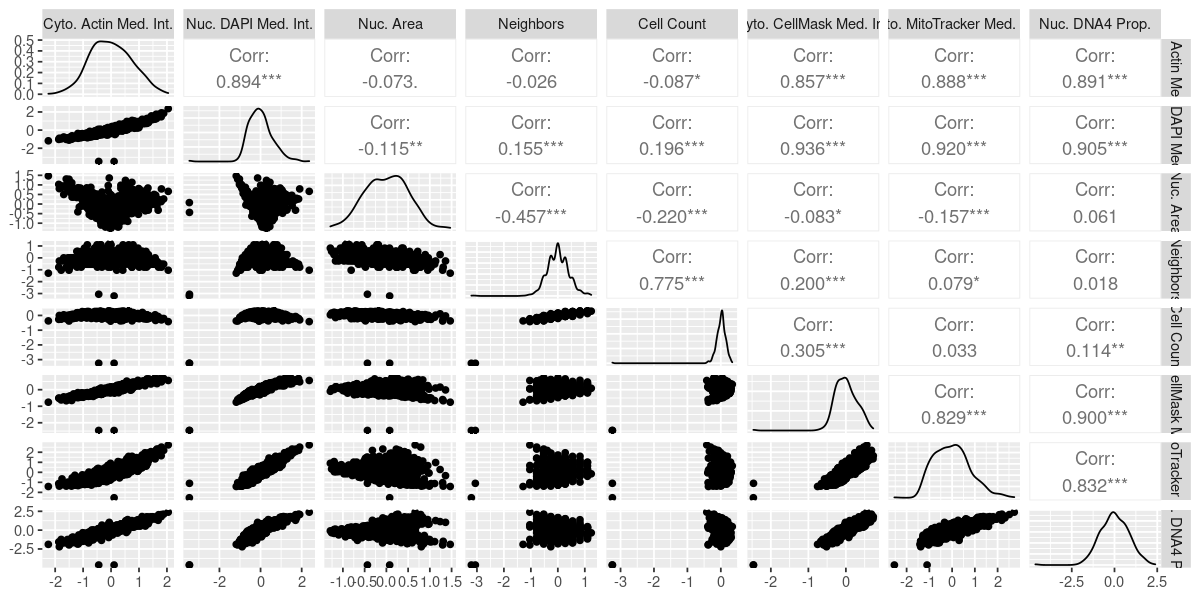

In [72]:
warn = getOption("warn")
options(warn=-1)

source('./plot_scripts/plot_fns.R')
sel_feats=c('Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR',
                     'Nuclei_CP_Intensity_MedianIntensity_Dapi_RR',
                     'Nuclei_CP_AreaShape_Area_RR',
                     'Nuclei_PA_AreaShape_Neighbors_RR',
                     'Spot_PA_SpotCellCount_RR',
                     'Cytoplasm_CP_Intensity_MedianIntensity_CellMask_RR',
                     'Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR',
                    'Nuclei_PA_Cycle_DNA4NProportion_RR')
short_names = c("Cyto. Actin Med. Int.",
           "Nuc. DAPI Med. Int.",
           "Nuc. Area",
           "Neighbors",
           "Cell Count",
           "Cyto. CellMask Med. Int.",
           "Cyto. MitoTracker Med. Int.",
           "Nuc. DNA4 Prop."
          )
sel_pw="LI8X00520.B04"

wp3=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Feature")

ws3=well_scatter(feats=sel_feats,
fnames = short_names,
pw=sel_pw)

wp3
ws3

options(warn=warn)

### Example 1.4

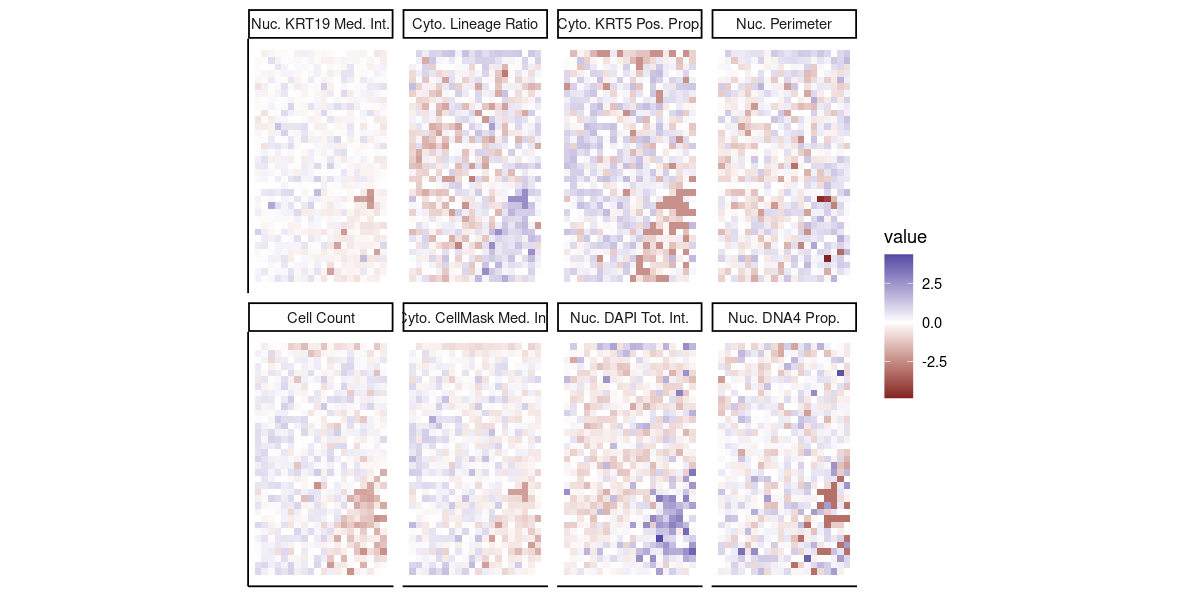

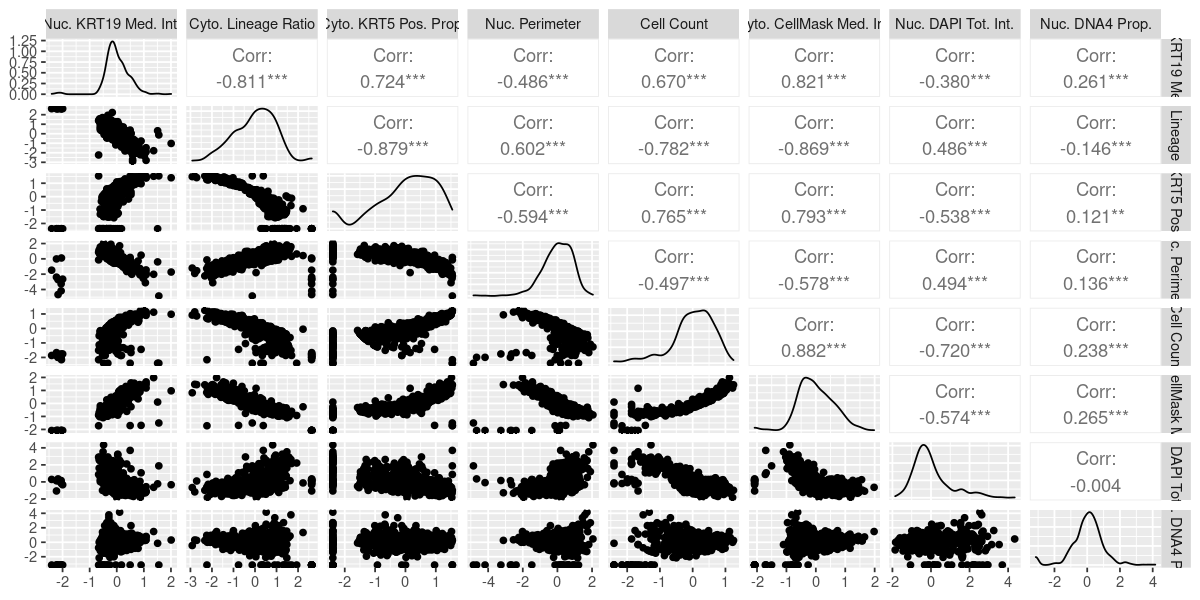

In [73]:
warn = getOption("warn")
options(warn=-1)

source('./plot_scripts/plot_fns.R')
sel_feats=c('Nuclei_CP_Intensity_MedianIntensity_KRT19_RR',
                         'Cytoplasm_PA_Intensity_LineageRatio_RR',
                         'Cytoplasm_PA_Gated_KRT5PositiveProportion_RR',
                         'Nuclei_CP_AreaShape_Perimeter_RR',
                         'Spot_PA_SpotCellCount_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_CellMask_RR',
                         'Cytoplasm_CP_Intensity_IntegratedIntensity_Dapi_RR',
                        'Nuclei_PA_Cycle_DNA4NProportion_RR')
short_names = c("Nuc. KRT19 Med. Int.",
               "Cyto. Lineage Ratio",
               "Cyto. KRT5 Pos. Prop.",
               "Nuc. Perimeter",
               "Cell Count",
               "Cyto. CellMask Med. Int.",
               "Nuc. DAPI Tot. Int.",
               "Nuc. DNA4 Prop."
              )
sel_pw="LI8X00513.A03"

wp4=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Feature")

ws4=well_scatter(feats=sel_feats,
fnames = short_names,
pw=sel_pw)

wp4
ws4

options(warn=warn)

## 2. Spatial shared across wells (same feature)

We also want to show that the same spatial features shows up across multiple wells (here, the same feature)

In [74]:
cmb = cbind(fmats[["Plate"]][,1],fmats[["Well"]][,1])
pws = apply(cmb,1,function(x)paste0(x,collapse="."))

### Example 2.1

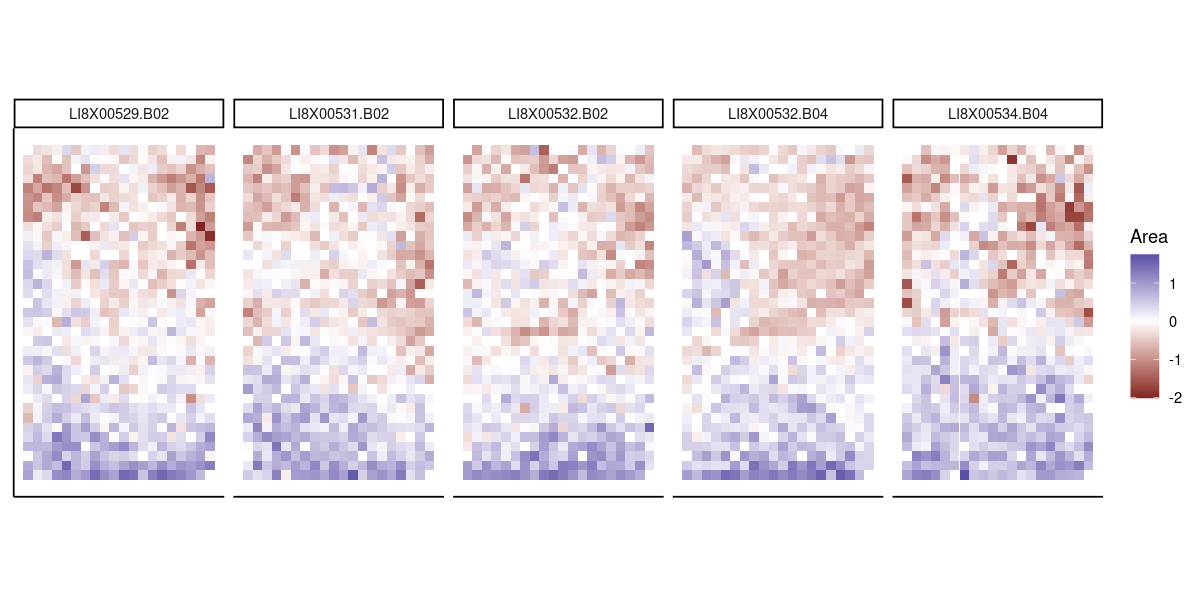

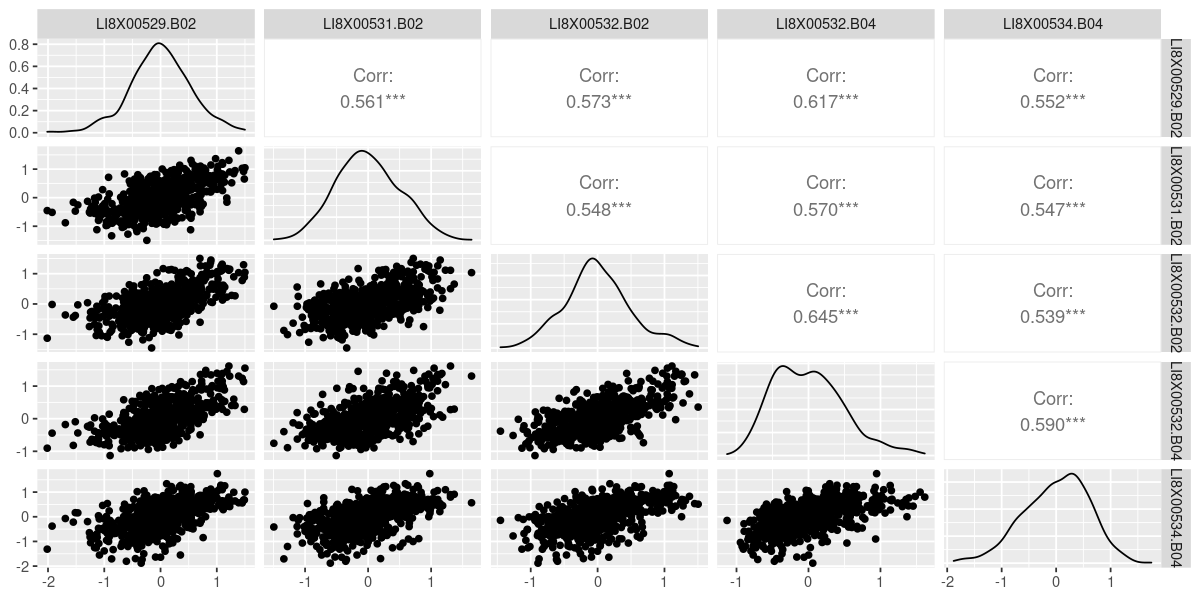

In [75]:
warn = getOption("warn")
options(warn=-1)

sel_feats='Nuclei_CP_AreaShape_Area_RR'
short_names = 'Area'
sel_pw=c("LI8X00529.B02", "LI8X00531.B02", "LI8X00532.B02", "LI8X00532.B04", "LI8X00534.B04")
    
wpw1=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Well",
scale_name="Area",nr=1)

wsw1=well_scatter_byw(feats=sel_feats,
fnames = short_names,
pw=sel_pw)

wpw1
wsw1

options(warn=warn)

### Example 2.2

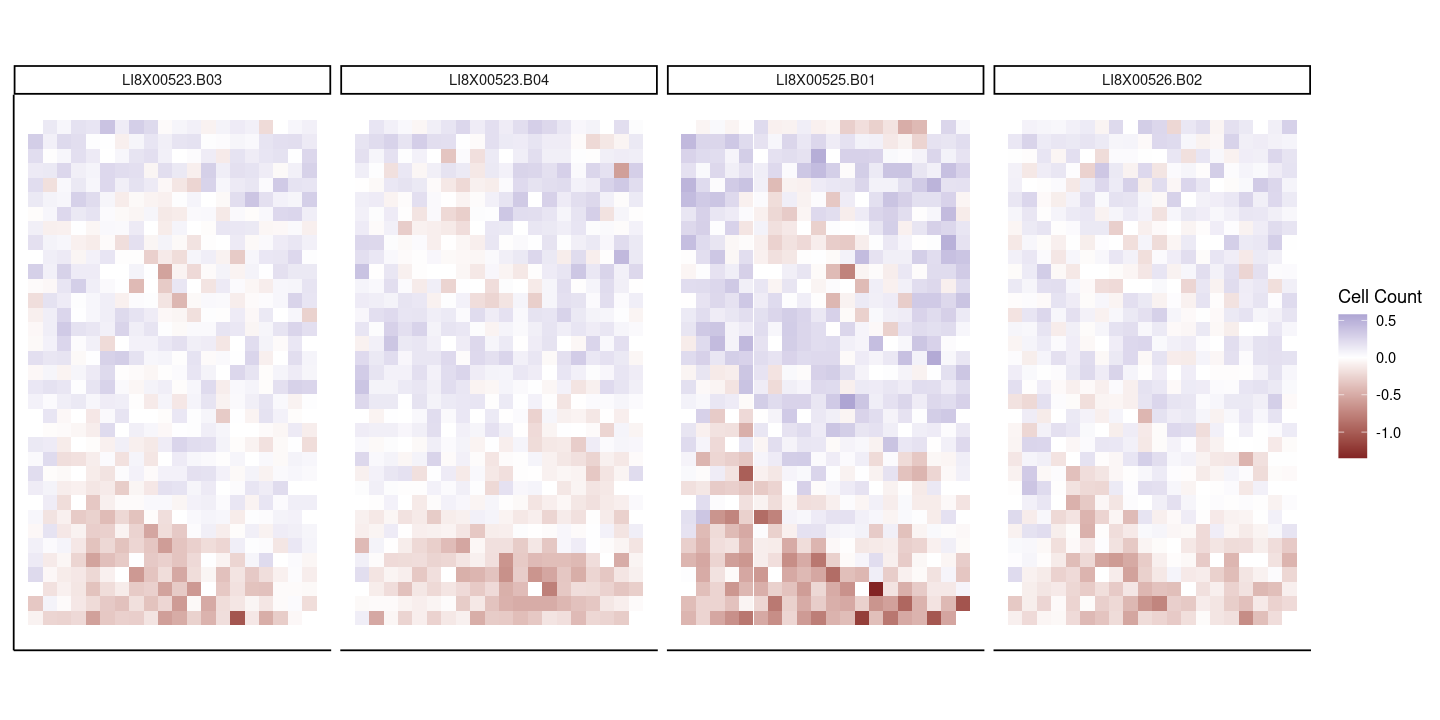

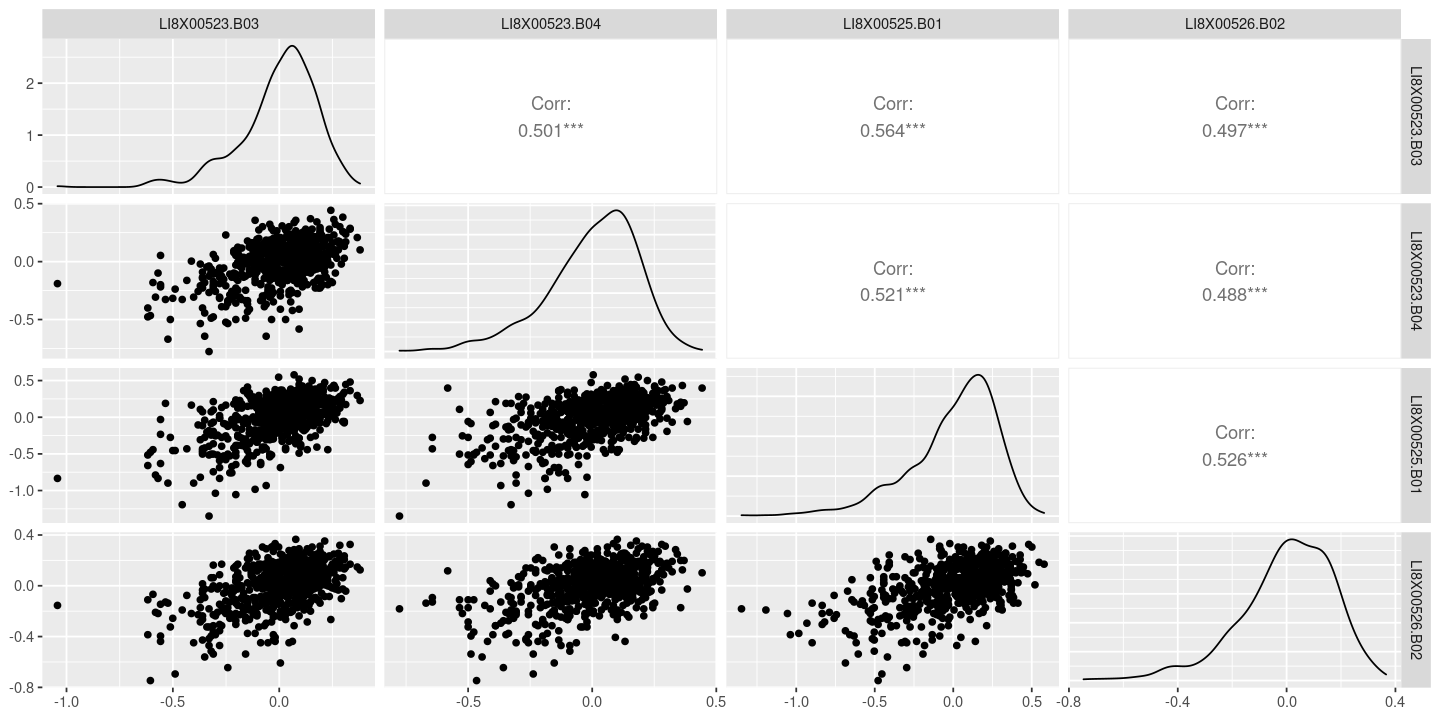

In [99]:
ft = 'Spot_PA_SpotCellCount_RR'
scc = fmats[[ft]]
cor_mat = cor(t(scc),use="na.or.complete")

sel_feats = ft
short_names = "Cell Count"

sel_pw=pws[order(cor_mat[which(pws=='LI8X00525.B01'),],decreasing=TRUE)[c(1,2,4,5)]]
           
wpw2=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Well",
scale_name=short_names,nr=1)

wsw2=well_scatter_byw(feats=sel_feats,
fnames = short_names,
pw=sel_pw)

wpw2
wsw2

### Example 2.3

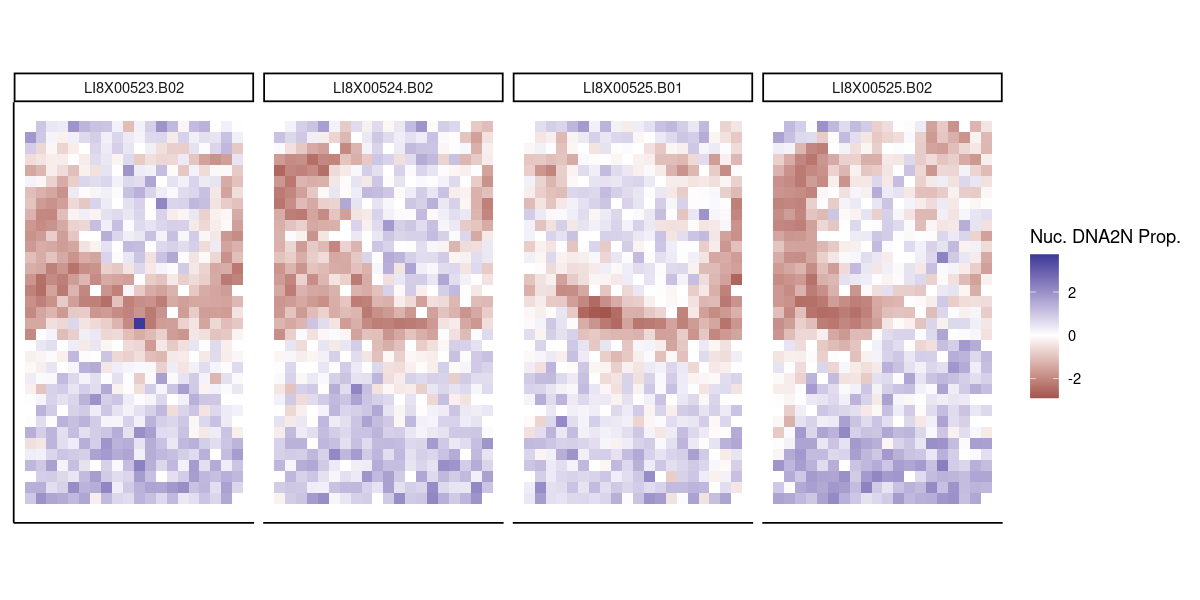

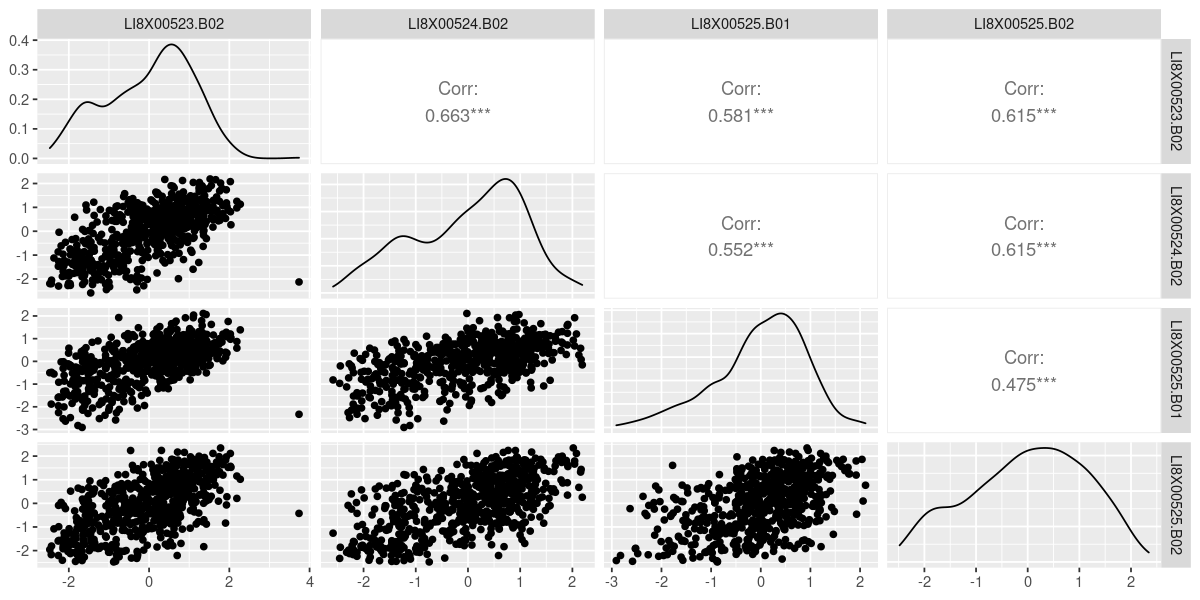

In [77]:
warn = getOption("warn")
options(warn=-1)

ft = 'Nuclei_PA_Cycle_DNA2NProportion_RR'
scc = fmats[[ft]] #fmat

# find wells that are highly cor with other wells generally
# we will search among these
cor_mat = cor(t(scc),use="pairwise.complete.obs")^2 # squared cors btwn wells

sel_feats=ft
short_names = 'Nuc. DNA2N Prop.'
sel_pw = pws[order(cor_mat[which(pws=='LI8X00523.B02'),],decreasing=TRUE)[1:4]]

wpw3=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Well",
scale_name=short_names,nr=1)

wsw3=well_scatter_byw(feats=sel_feats,
fnames = short_names,
pw=sel_pw)            

wpw3
wsw3        

options(warn=warn)

### Example 2.4

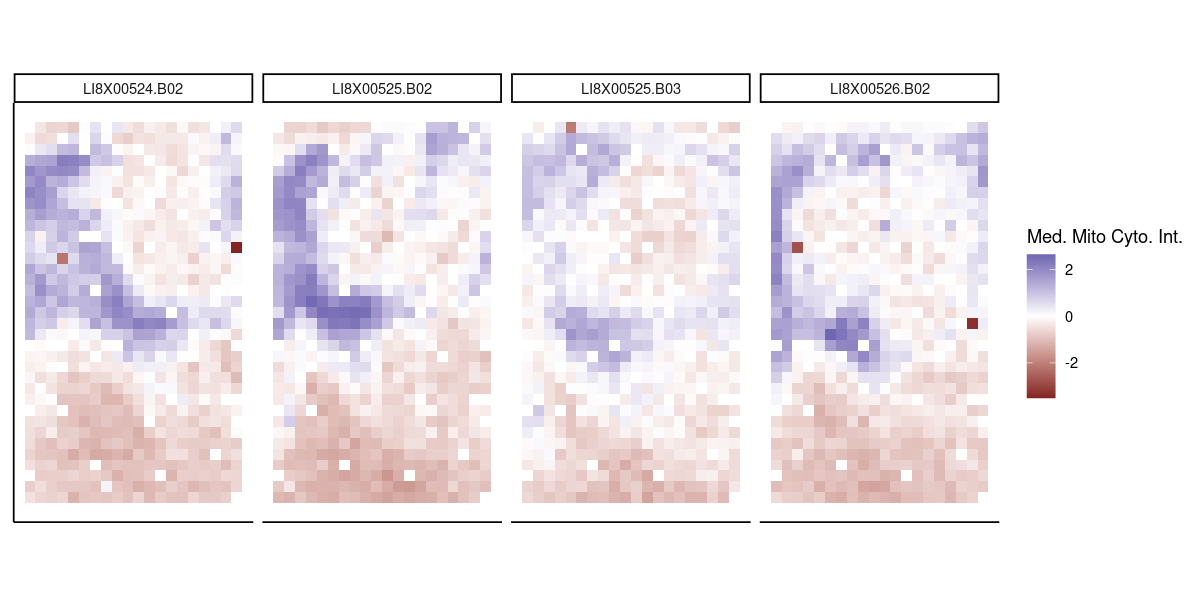

In [78]:
warn = getOption("warn")
options(warn=-1)

ft = 'Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR'
scc = fmats[[ft]] #fmat

# find wells that are highly cor with other wells generally
# we will search among these
cor_mat = cor(t(scc),use="pairwise.complete.obs")^2 # squared cors btwn wells
qcors = apply(cor_mat,1,quantile,.9,na.rm=TRUE) 
oqc = order(qcors,decreasing=TRUE)

#plate.well names
cmb = cbind(fmats[["Plate"]][,1],fmats[["Well"]][,1]) 
pws = apply(cmb,1,function(x)paste0(x,collapse="."))

# choose top correlated 
N=20
chse = sort(unique(pws[oqc][1:N]))
chse = chse[c(9,13:14,18)]

sel_feats=ft
short_names = 'Med. Mito Cyto. Int.'
sel_pw = chse

wpw4=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Well",
scale_name=short_names,nr=1)

wsw4=well_scatter_byw(feats=sel_feats,
fnames = short_names,
pw=sel_pw)            

wpw4
wsw4        

options(warn=warn)

## 3. Adjusted Data Removes Spatial Effects

We now want to show what our approach looks like after removing the spatial effects. We recapitulate some previous two plots but now using the adjusted data. 

## Example 3.1 -- adjusted example 2.1

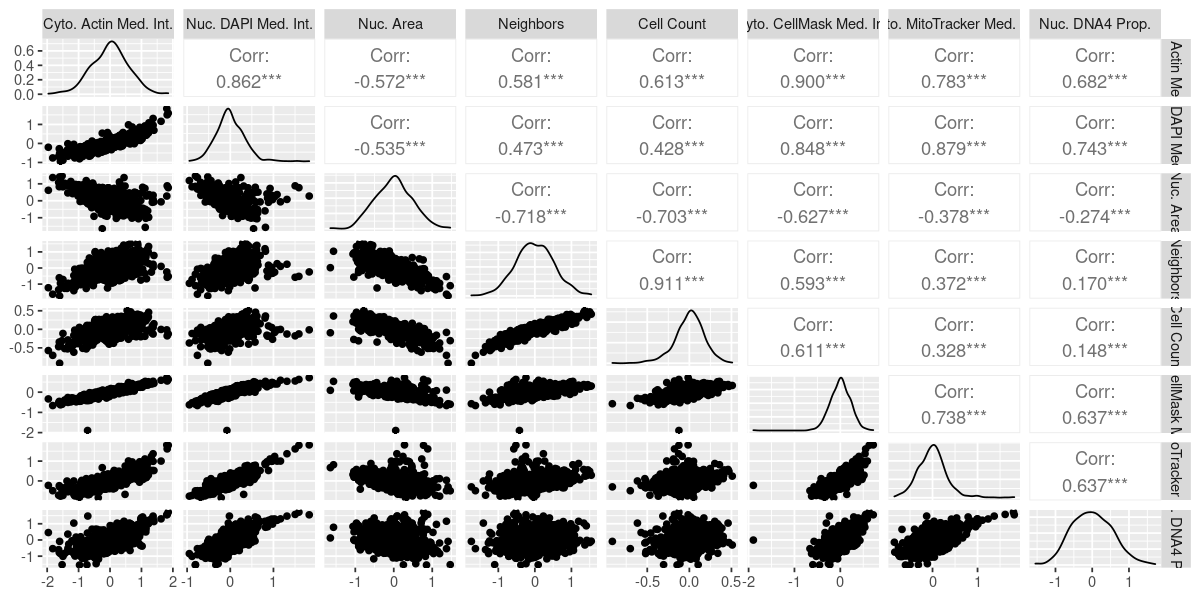

In [79]:
warn = getOption("warn")
options(warn=-1)


sel_feats = c('Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR',
                         'Nuclei_CP_Intensity_MedianIntensity_Dapi_RR',
                         'Nuclei_CP_AreaShape_Area_RR',
                         'Nuclei_PA_AreaShape_Neighbors_RR',
                         'Spot_PA_SpotCellCount_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_CellMask_RR',
                         'Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR',
                        'Nuclei_PA_Cycle_DNA4NProportion_RR')
sel_feats = paste0(sel_feats,"_ADJ")
short_names = c("Cyto. Actin Med. Int.",
               "Nuc. DAPI Med. Int.",
               "Nuc. Area",
               "Neighbors",
               "Cell Count",
               "Cyto. CellMask Med. Int.",
               "Cyto. MitoTracker Med. Int.",
               "Nuc. DNA4 Prop."
              )
sel_pw = "LI8X00525.A01"

wp1=well_plot(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw,
    facet="~Feature")

ws1=well_scatter(feats=sel_feats,
    fnames = short_names,
    pw=sel_pw)

wp1
ws1

options(warn=warn)

### Example 4.2 -- adjusted example 3.1

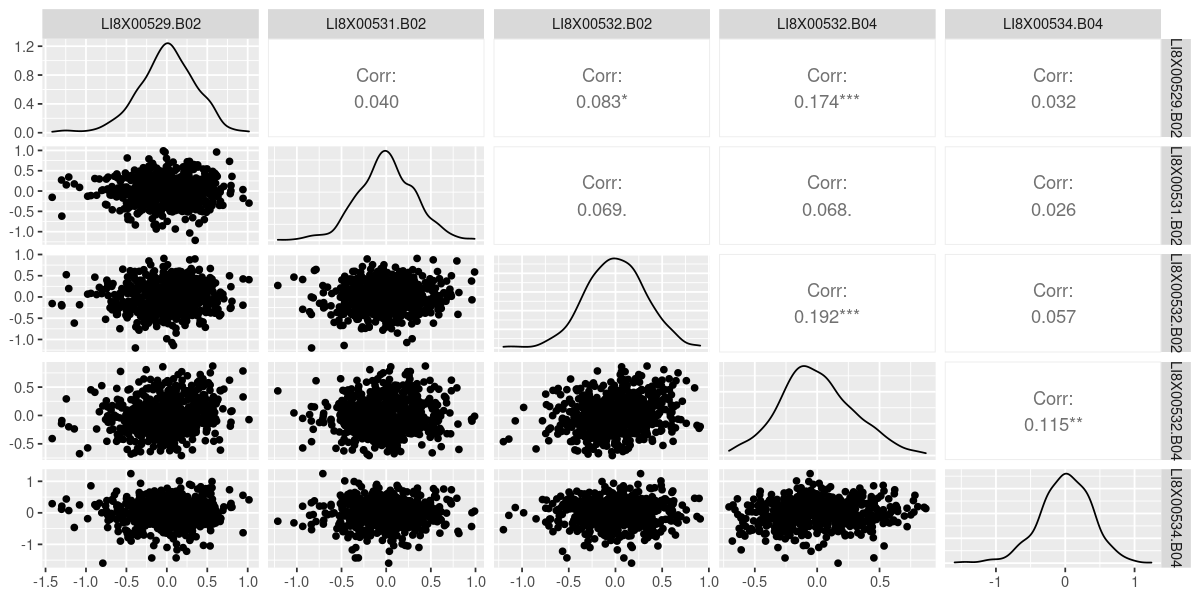

In [80]:
warn = getOption("warn")
options(warn=-1)

sel_feats='Nuclei_CP_AreaShape_Area_RR_ADJ'
short_names = 'Area'
sel_pw=c("LI8X00529.B02", "LI8X00531.B02", "LI8X00532.B02", "LI8X00532.B04", "LI8X00534.B04")
    
wpw1=well_plot(feats=sel_feats,
fnames = short_names,
pw=sel_pw,
facet="~Well",
scale_name="Area",nr=1)

wsw1=well_scatter_byw(feats=sel_feats,
fnames = short_names,
pw=sel_pw)

wpw1
wsw1

options(warn=warn)

in both cases we can see that the spatial effects have disappeared. 

## 5. Biology is preserved and enhanced (specific feature)

In addition to removing the spatial effects, we need to show that this will not harm the biological signal. First we'll look at median cytoplasmic actin intensity as an example.

In [81]:
ft = "Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR"
svd1 = memanorm::average_svd_na(fmats[ft])
svd1_adj = memanorm::average_svd_na(fmats[ft%+%"_ADJ"])

First, let's look a bit more at how the spatial effect manifest before/after adjustment. 

### Example 5.1 -- PCA Scatter: Spatial Distribution

In [82]:
sctr=asvd_compare(svd1,svd1_adj,fn=asvd_scatter_layout,hl="PrintRow")
sctr

### Example 5.2 -- Spatial Distribution

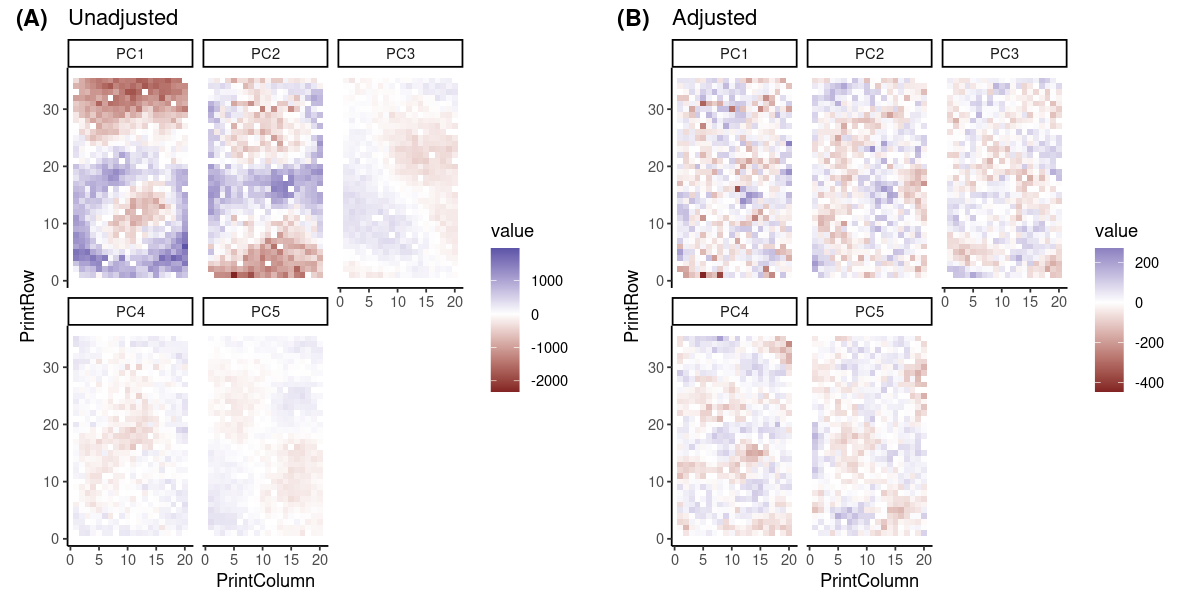

In [85]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_grid(asvd_layout(svd1,k=5,"Unadjusted"),
          asvd_layout(svd1_adj,k=5,"Adjusted"),
          labels=c('(A)','(B)'),nrow=1)

Now we can look at how well the ECMps cluster before/after adjustment. First we'll look at all ECMps together.

### Example 5.3 -- PCA Scatter: ECMp clustering

In [89]:
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(svd1,svd1_adj,rw_leg=.5)
sctr

Now, we can highlight specific ECMps.

### Example 5.4 -- PCA Scatter: THBS1|1 Clustering

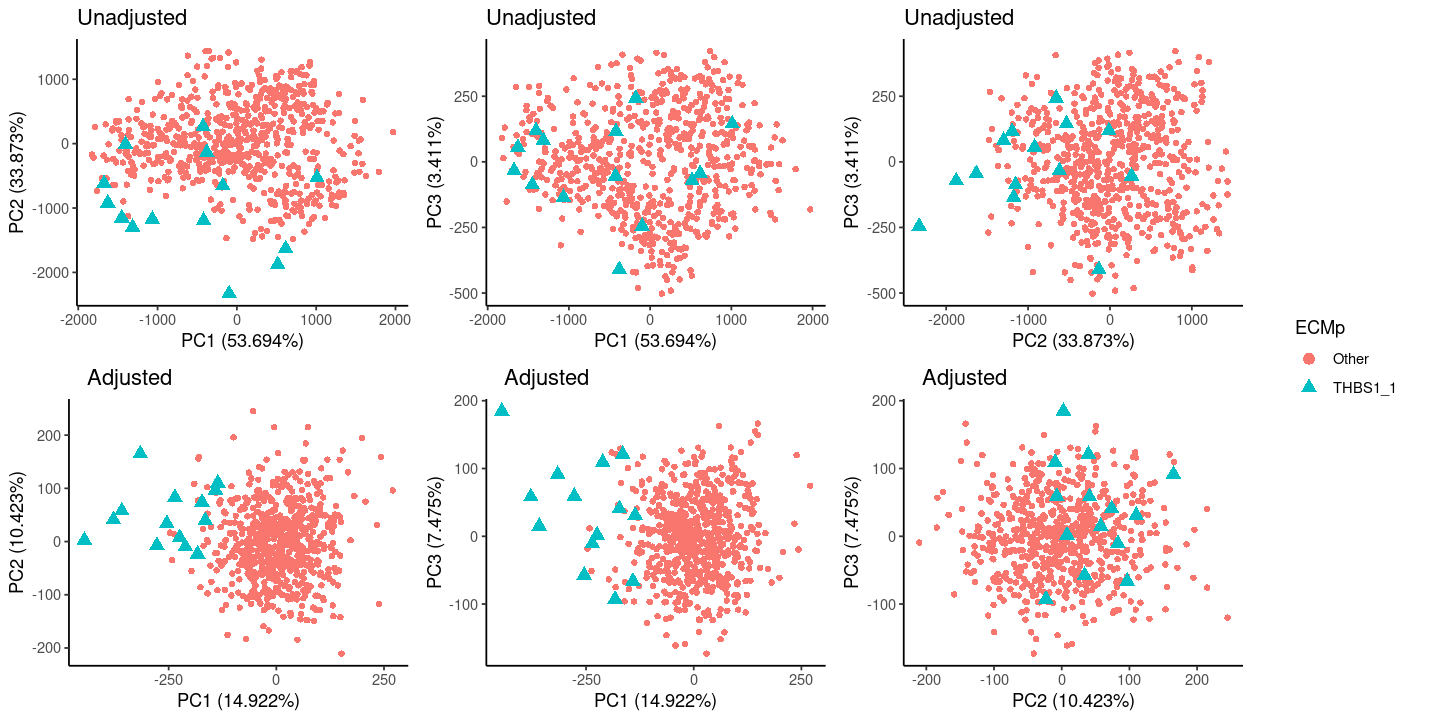

In [90]:
source('plot_scripts/plot_fns.R')
hl="THBS1_1"
options(repr.plot.width = 12, repr.plot.height = 6)
sctr=asvd_compare(svd1,svd1_adj,hl=hl)
sctr

### Example 5.5 -- PCA Scatter: FN1|1 Clustering

In [91]:
source('plot_scripts/plot_fns.R')
hl="FN1_1"
options(repr.plot.width = 12, repr.plot.height = 6)
sctr=asvd_compare(svd1,svd1_adj,hl=hl)
sctr

### Example 5.6 -- PCA Scatter: FBN1 Clustering

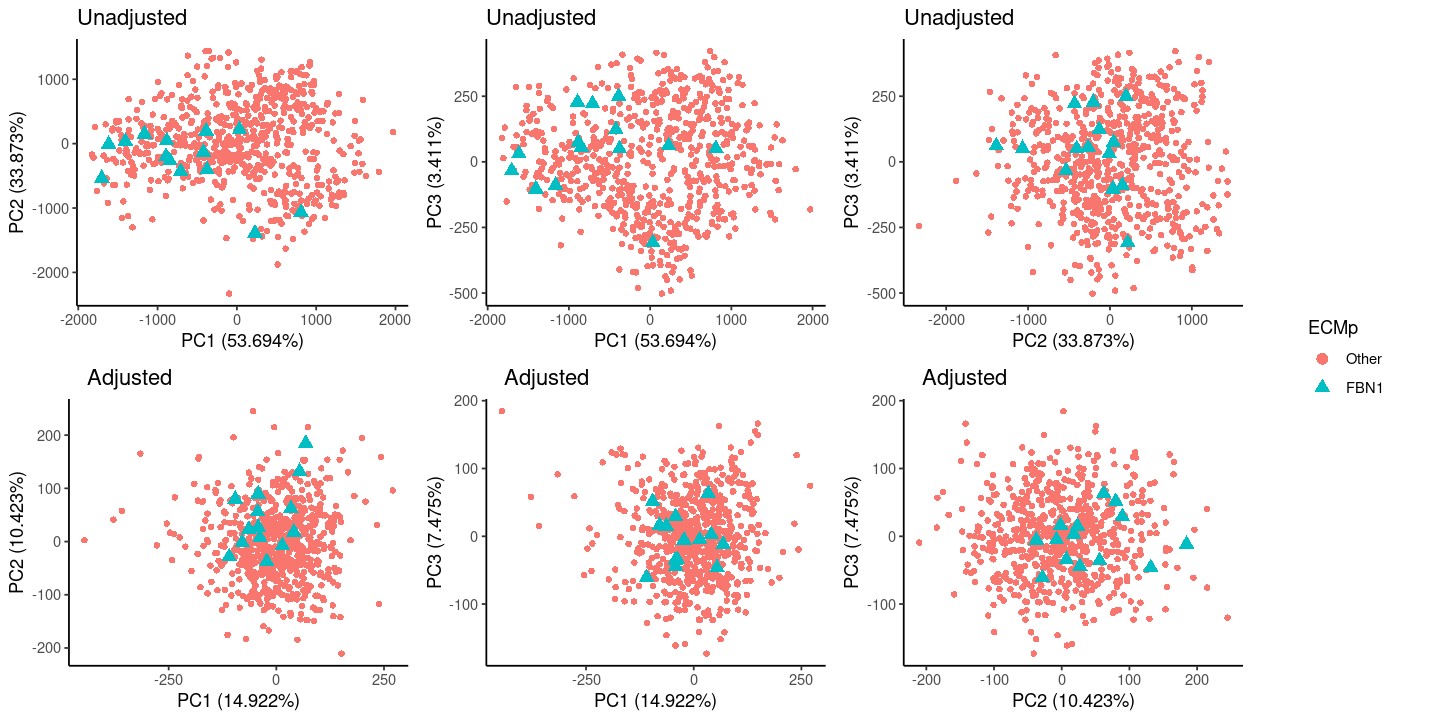

In [92]:
source('plot_scripts/plot_fns.R')
hl="FBN1"
options(repr.plot.width = 12, repr.plot.height = 6)
sctr=asvd_compare(svd1,svd1_adj,hl=hl)
sctr

### Example 5.7 -- PCA Scatter: CDH15 Clustering

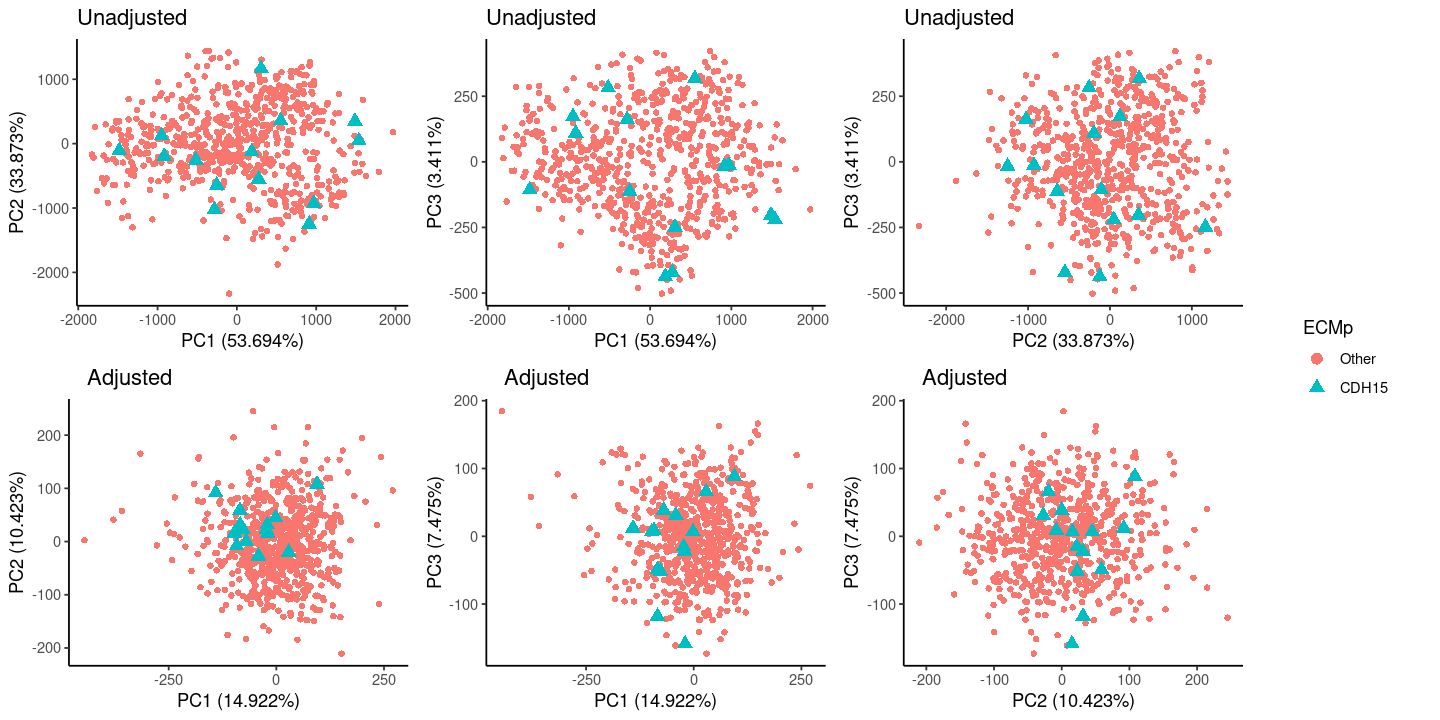

In [113]:
source('plot_scripts/plot_fns.R')
hl="CDH15"
options(repr.plot.width = 12, repr.plot.height = 6)
sctr=asvd_compare(svd1,svd1_adj,hl=hl)
sctr

### Example 5.8 -- PCA Scatter: COL2A1|2 Clustering

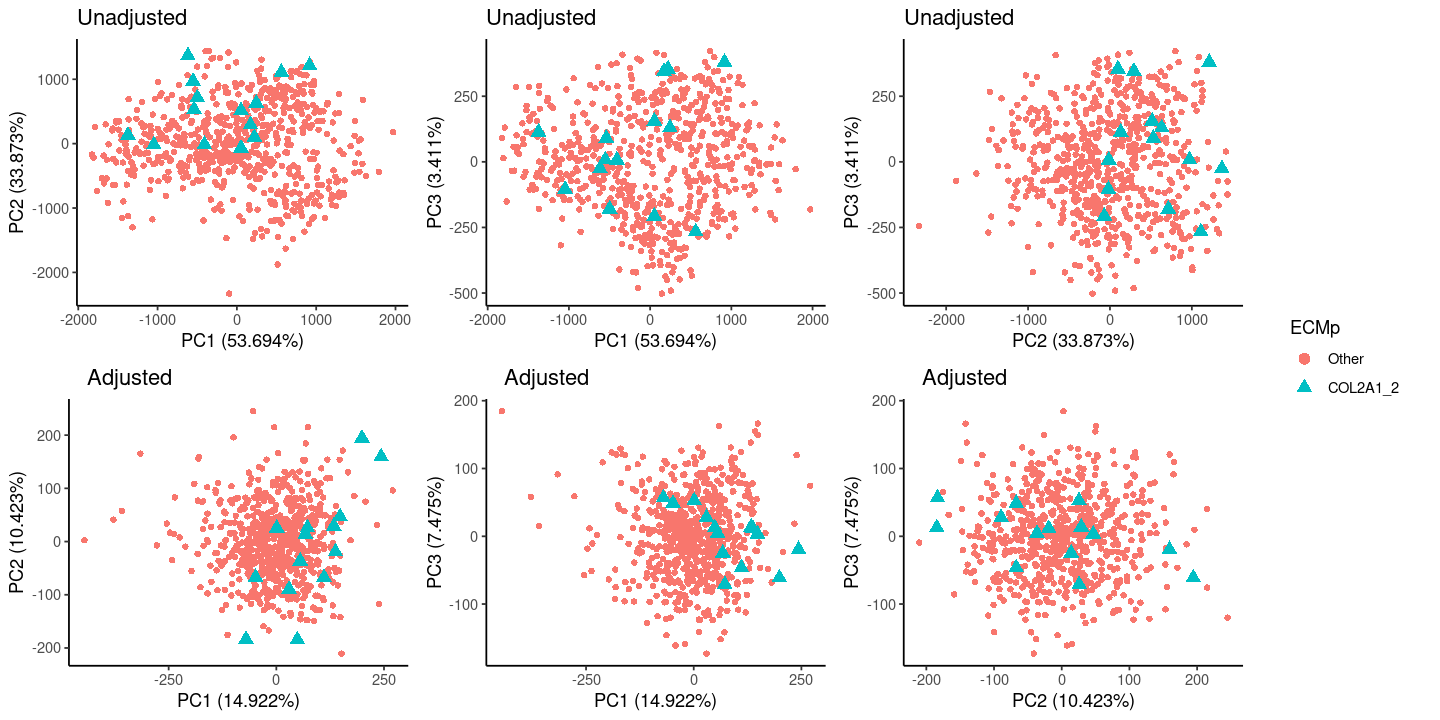

In [114]:
source('plot_scripts/plot_fns.R')
hl="COL2A1_2"
options(repr.plot.width = 12, repr.plot.height = 6)
sctr=asvd_compare(svd1,svd1_adj,hl=hl)
sctr

### Example 5.9 -- Overall Clustering metric: lower WSS/TSS

We can summarize all of this by looking at the within-group sum of squares normalized by the total sum of squares. This gives a measure of how well the ECMp clusters. When we do this we can see that adjusting the data typically gives (much) smaller (normalized) within-group SS and thus the ECMps more tightly cluster. 

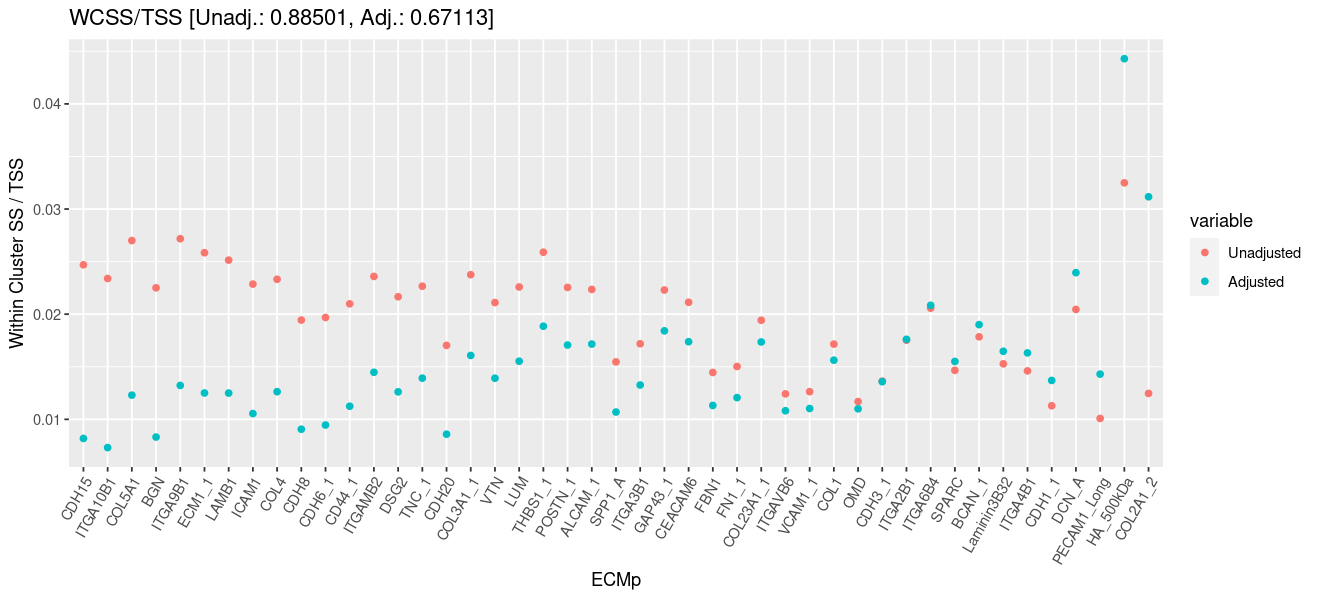

In [122]:
source('plot_scripts/plot_fns.R')
cmp = bcss_compare(svd1,svd1_adj)
ttl = paste0("WCSS/TSS [",paste0(c("Unadj.","Adj."),": ",round(cmp$bt,5),collapse=", "),"]")

options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(data=cmp$mbc,mapping=aes(x=ECMp,y=value,color=variable))+geom_point()+
  theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))+
  labs(y="Within Cluster SS / TSS")+ggtitle(ttl)

## 6. Biology is preserved and enhanced (across multiple features)

We can also summarize across many features by looking at the average SVD across features. We're going to consider the "Batch 1 features" -- i.e. features only measured in staining batch 1, 

In [102]:
ss1_rr = grep("_RR$",names(which(feature_batch=="1")),value=TRUE)
ss1_rr_adj = grep("_RR_ADJ$",names(which(feature_batch=="1")),value=TRUE)
ss1_rr

[1] "Cells_CP_Intensity_IntegratedIntensity_Actin_RR"          
[2] "Cells_CP_Intensity_IntegratedIntensity_MitoTracker_RR"    
[3] "Cells_CP_Intensity_MedianIntensity_Actin_RR"              
[4] "Cells_CP_Intensity_MedianIntensity_MitoTracker_RR"        
[5] "Cytoplasm_CP_Intensity_IntegratedIntensity_Actin_RR"      
[6] "Cytoplasm_CP_Intensity_IntegratedIntensity_MitoTracker_RR"
[7] "Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR"          
[8] "Cytoplasm_CP_Intensity_MedianIntensity_MitoTracker_RR"

Our first set of plots is going to be scatter plots after the data has been projected down onto the first two PCs. First we calculate the Average PCA/SVD (ASVD) for the batch 1 features and again visualize the spatial patterns. 

In [103]:
ss1_feats_cent = fmats[ss1_rr]#lapply(fmats[ss1_rr],function(x)t(scale(t(x),center=FALSE,scale=FALSE)))
ss1_adj_feats_cent = fmats[ss1_rr_adj]#lapply(fmats[ss1_rr_adj],function(x)t(scale(t(x),center=FALSE,scale=FALSE)))
asvd1_rr = memanorm::average_svd_na(ss1_feats_cent)
asvd1_rr_adj = memanorm::average_svd_na(ss1_adj_feats_cent)

### Example 6.1 -- PCA Scatter: Spatial Distribution

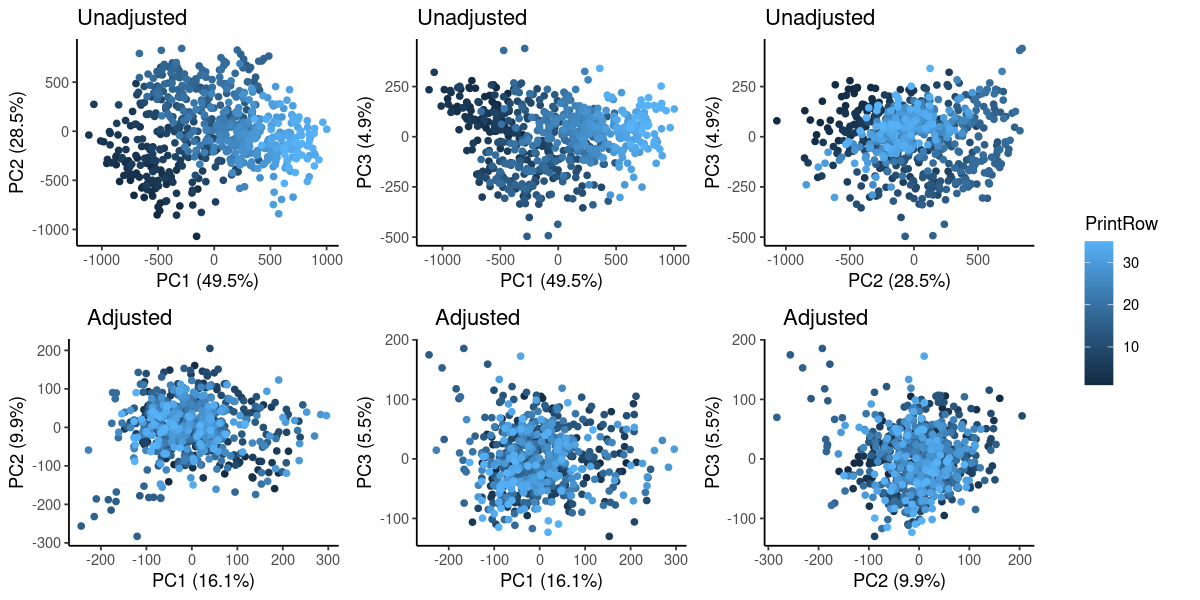

In [104]:
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,fn=asvd_scatter_layout,hl="PrintRow")
sctr

### Example 6.2 -- Spatial Distribution

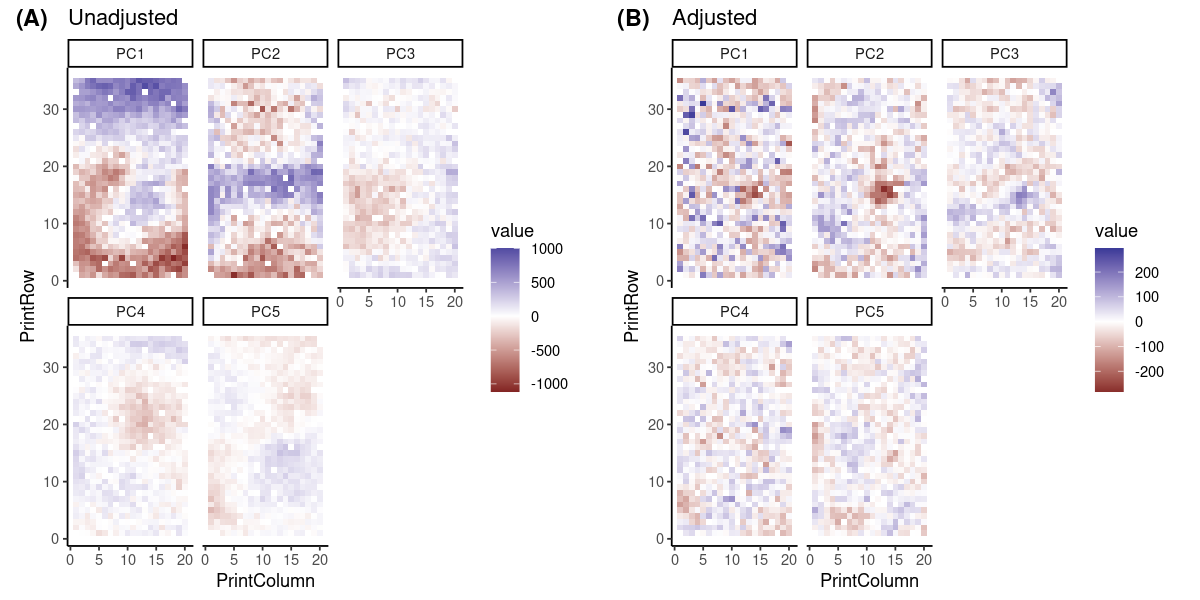

In [105]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_grid(asvd_layout(asvd1_rr,k=5,"Unadjusted"),
          asvd_layout(asvd1_rr_adj,k=5,"Adjusted"),
          labels=c('(A)','(B)'),nrow=1)

### Example 6.3 -- PCA Scatter: ECMp clustering

We can now look at how well ECMps cluster. First, we consider all ECMps together. 

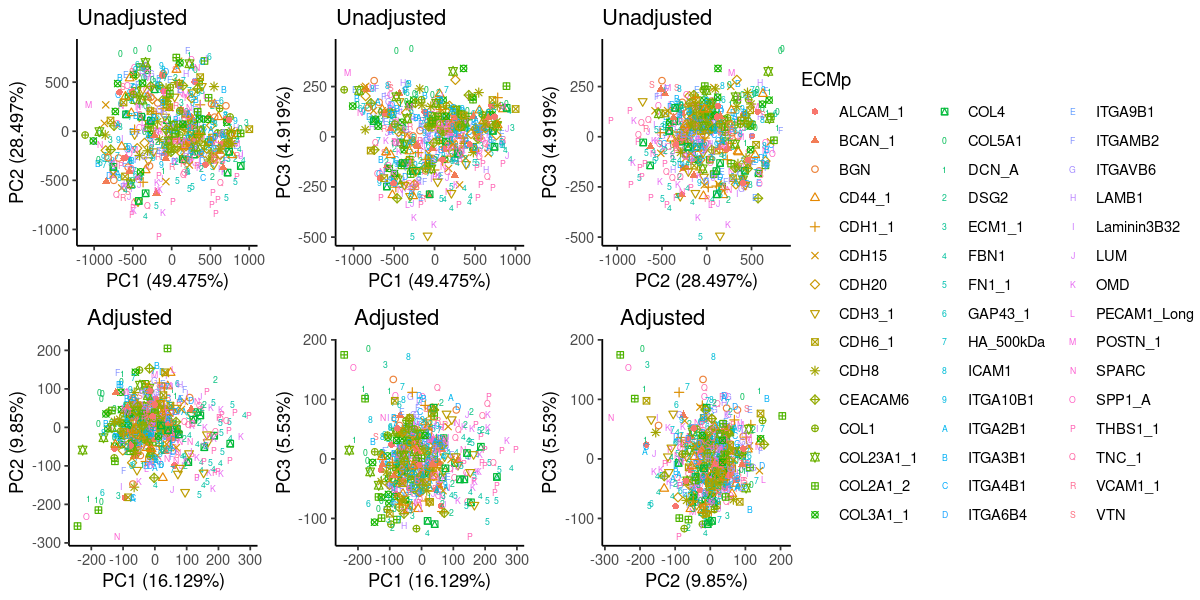

In [107]:
source('plot_scripts/plot_fns.R')
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,rw_leg=.5)
sctr

### Example 6.4 -- PCA Scatter: THBS1|1 Clustering

We'll now highlight specific ECMps

In [108]:
hl="THBS1_1"
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,hl=hl)
sctr

### Example 6.5 -- PCA Scatter: FN1|1 Clustering

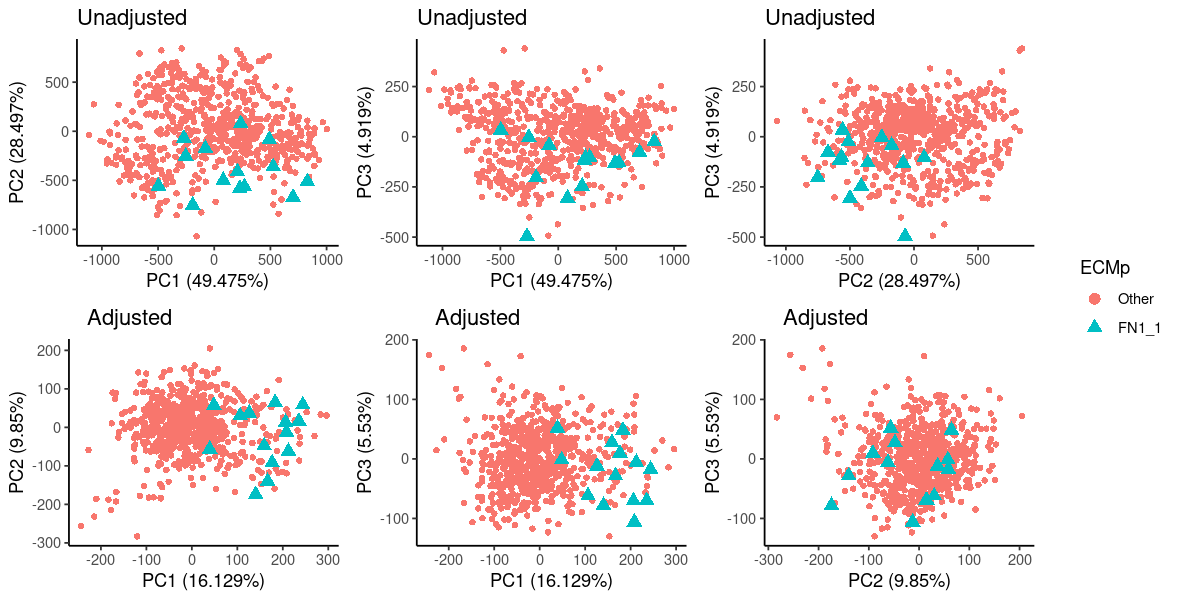

In [109]:
hl="FN1_1"
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,hl=hl)
sctr

### Example 6.6 -- PCA Scatter: FBN1 Clustering

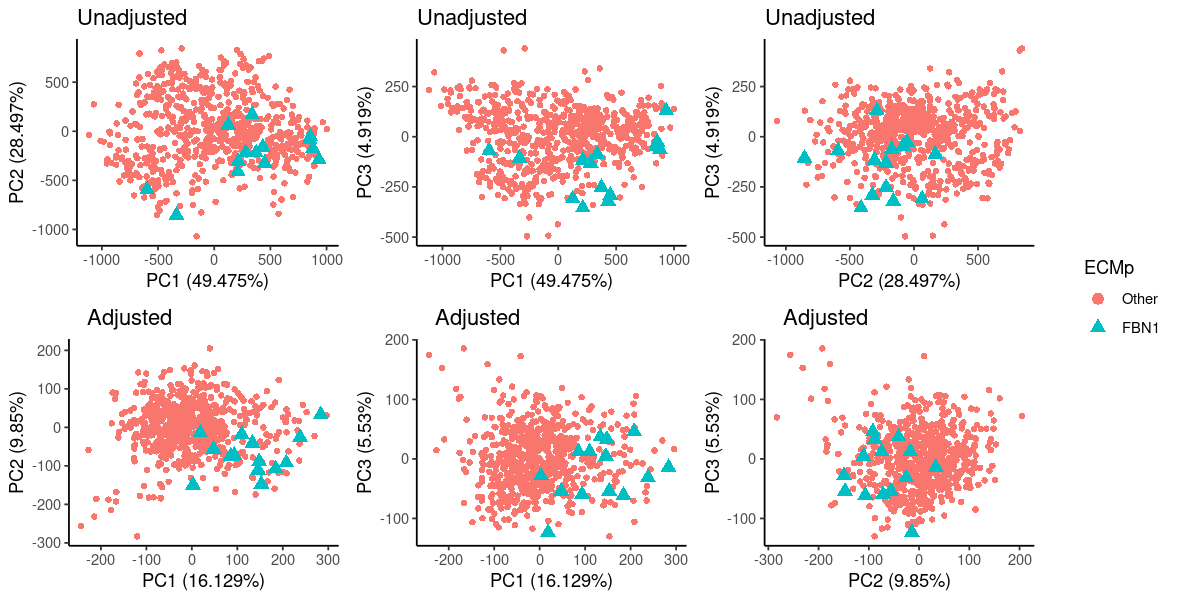

In [110]:
hl="FBN1"
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,hl=hl)
sctr

### Example 6.7 -- PCA Scatter: CDH15 Clustering

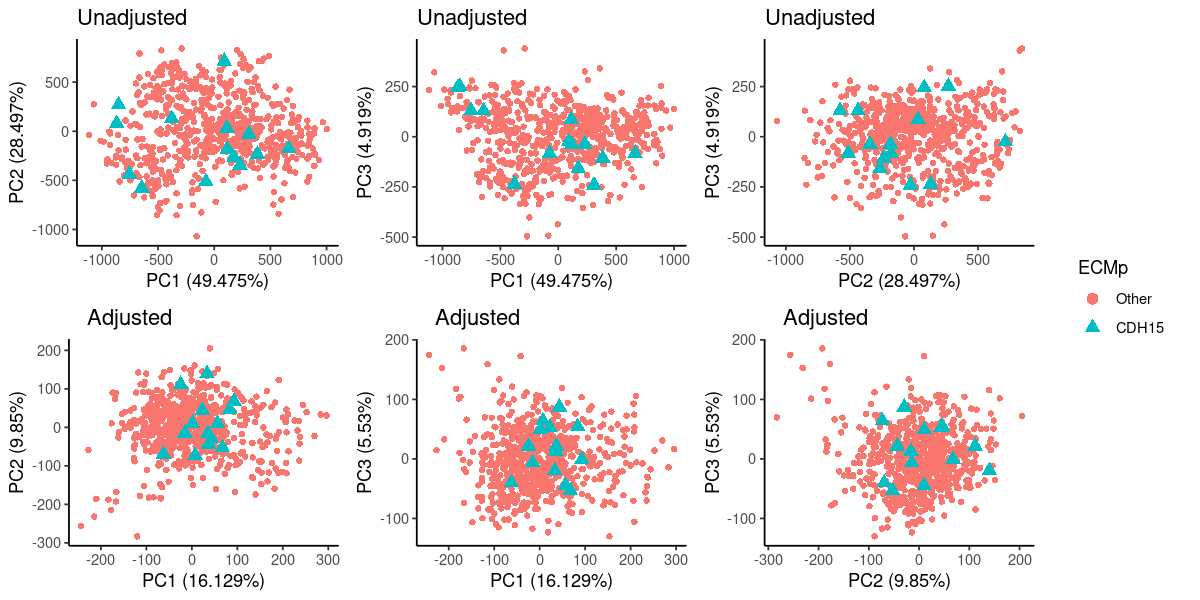

In [115]:
hl="CDH15"
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,hl=hl)
sctr

### Example 6.8 -- PCA Scatter: COL2A1|2 Clustering

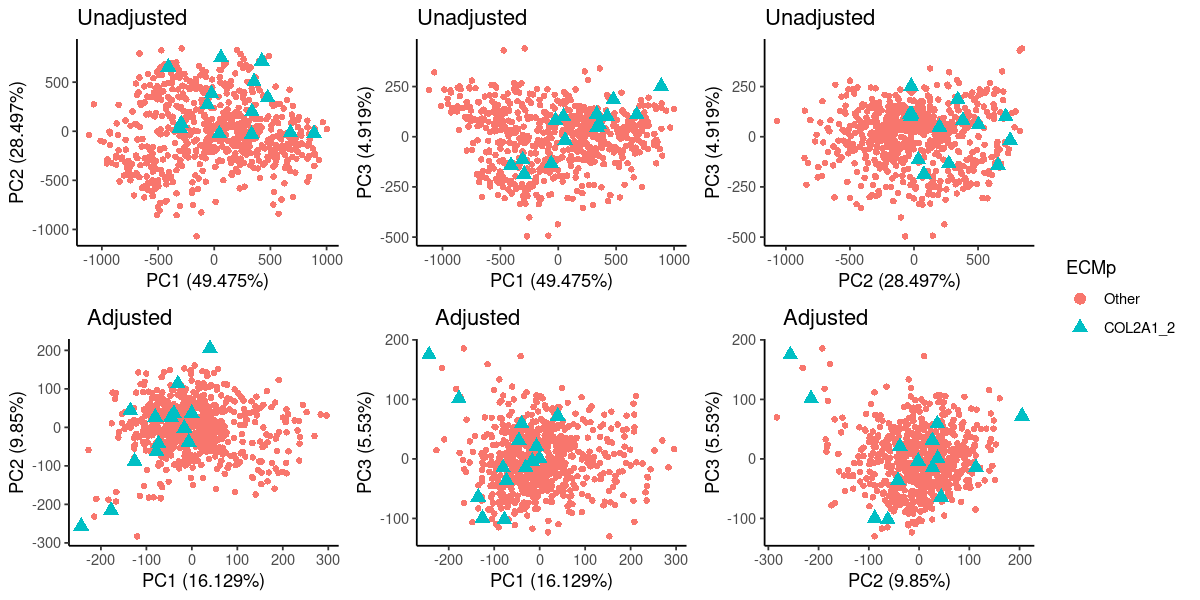

In [116]:
hl="COL2A1_2"
options(repr.plot.width = 10, repr.plot.height = 5)
sctr=asvd_compare(asvd1_rr,asvd1_rr_adj,hl=hl)
sctr

### Example 6.9 -- Overall Clustering metric: lower WSS/TSS
We can summarize all of this by looking at the within-group sum of squares normalized by the total sum of squares. This gives a measure of how well the ECMp clusters. When we do this we can see that adjusting the data typically gives (much) smaller (normalized) within-group SS and thus the ECMps more tightly cluster. 

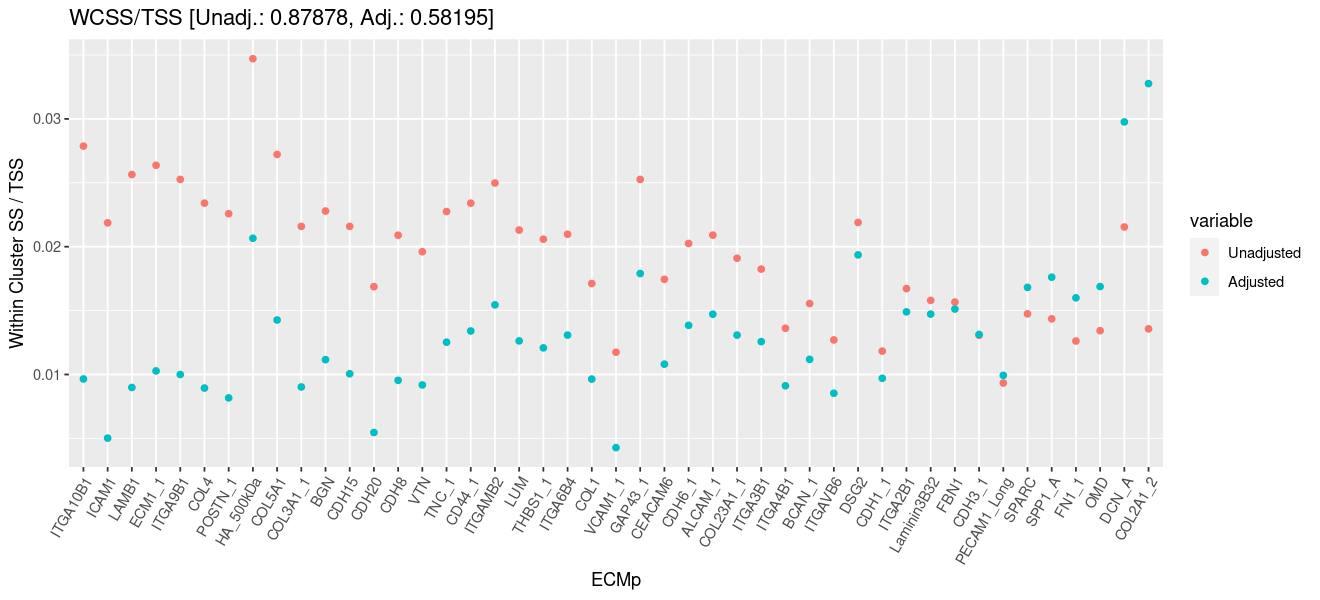

In [121]:
cmp = bcss_compare(asvd1_rr,asvd1_rr_adj)
ttl = paste0("WCSS/TSS [",paste0(c("Unadj.","Adj."),": ",round(cmp$bt,5),collapse=", "),"]")

options(repr.plot.width = 11, repr.plot.height = 5)
ggplot(data=cmp$mbc,mapping=aes(x=ECMp,y=value,color=variable))+geom_point()+
  theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))+
  labs(y="Within Cluster SS / TSS")+ggtitle(ttl)

## 7. Spatial Effects Learned

### Example 7.1 -- Unwanted Features Learned
We can directly look at the spatial effects learned (and regressed out) by looking at the PCs for the features measured in all batches. Here, we plot the 15 that are regressed out. 

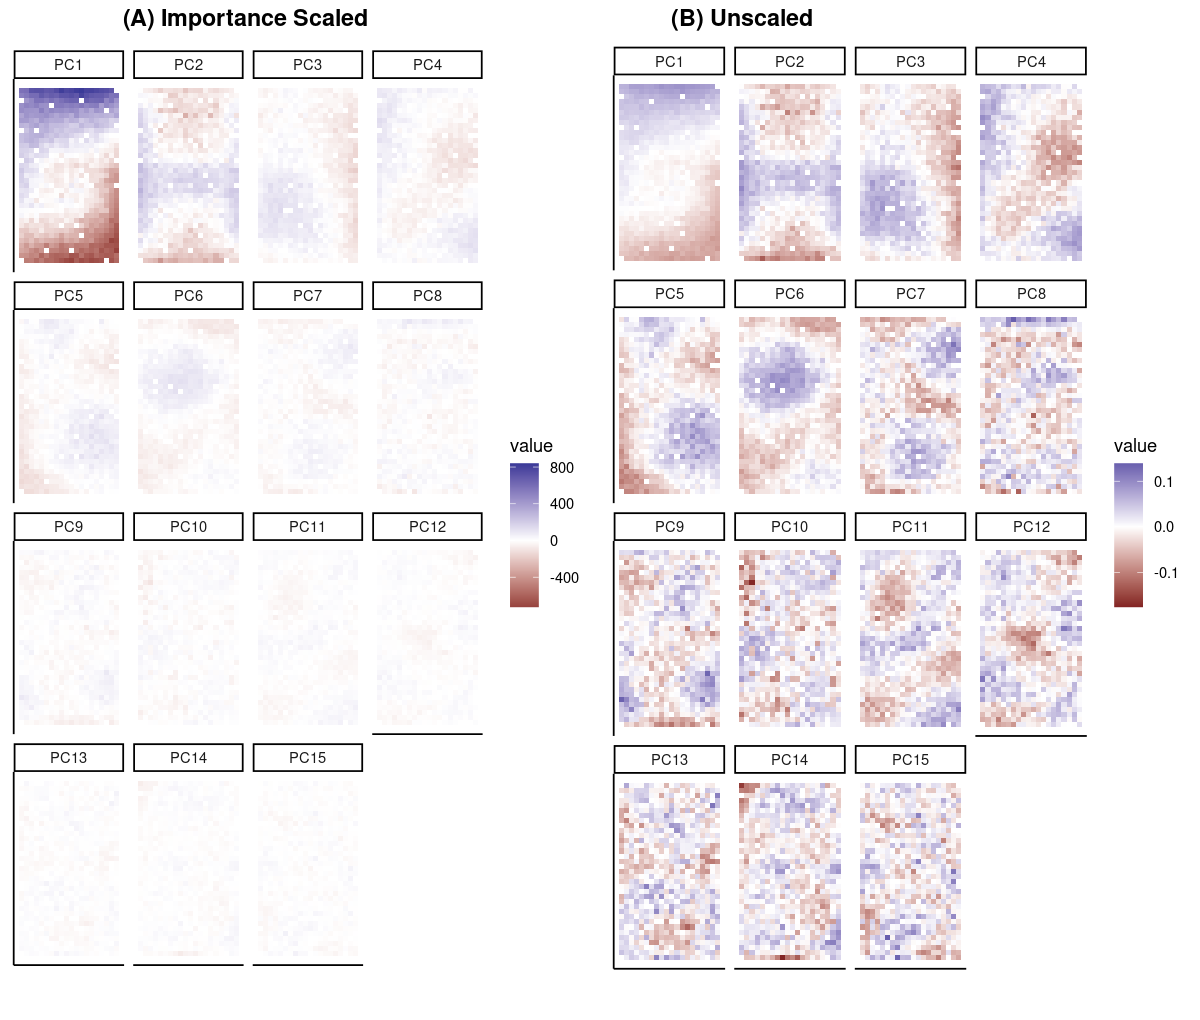

In [126]:
source('plot_scripts/plot_fns.R')
ss123_rr = grep("_RR$",names(which(feature_batch=="123")),value=TRUE)
ss123_feats_cent = lapply(fmats[ss123_rr],function(x)t(scale(t(x),center=TRUE,scale=FALSE)))
asvd123_rr = memanorm::average_svd_na(ss123_feats_cent)
options(repr.plot.width = 5, repr.plot.height = 10)                      
plt1 = asvd_layout(asvd123_rr,k=15)+labs(x=NULL,y=NULL)+theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank())+
            theme(axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank())
                          
plt2 = asvd_layout(asvd123_rr,k=15,scale=FALSE)+labs(x=NULL,y=NULL)+theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank())+
            theme(axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank())
                          
options(repr.plot.width = 10, repr.plot.height = 8.5)
plot_grid(plt1,plt2,nrow=1,labels=c('(A) Importance Scaled','(B) Unscaled'))                    

### Example 7.2 -- Pct. of Variance Explained by Unwanted Features (example feature)

We can also look at an R^2 value for how much each of these spatial features shows up in the data. This gives us a sense of how much the features can be improved by removing the spatial effects. 

No id variables; using all as measure variables



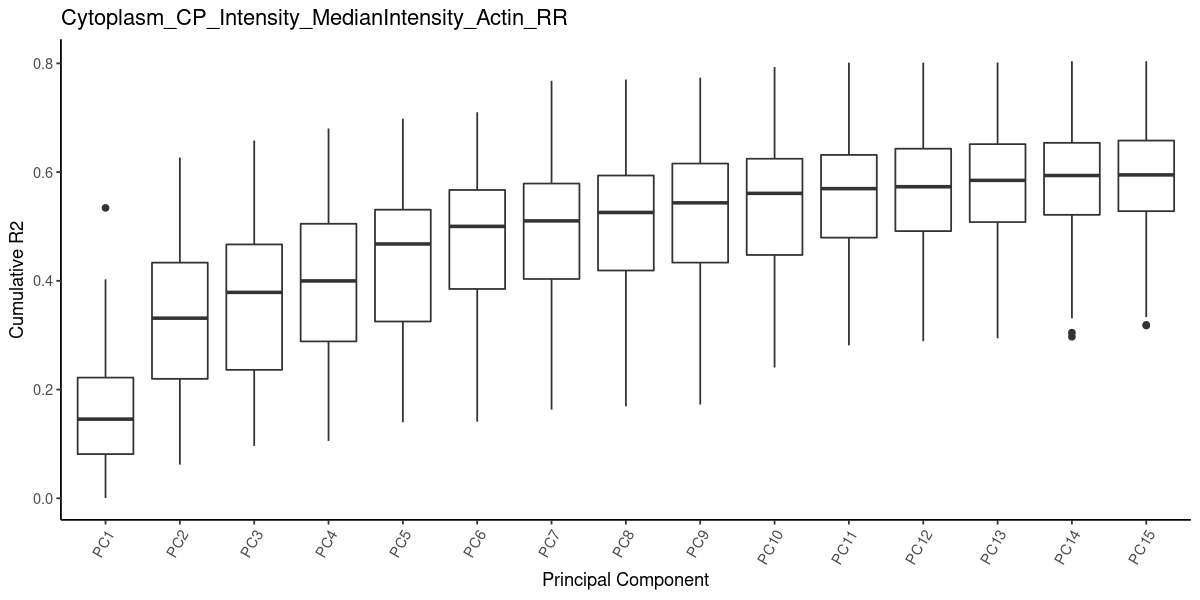

In [154]:
ft="Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR"
cor_with_pc=function(k,fmat)sapply(1:nrow(fmat),function(i)cor(data.frame(V)[,k],unlist(fmat[i,])))
V = vdf(asvd123_rr,scale=FALSE)$v                         
cors = sapply(1:dm,function(k)cor_with_pc(k,fmats[[ft]])^2)
cors = t(apply(cors,1,cumsum))
cors = data.frame(cors)
colnames(cors) = paste0('PC',1:dm)
mcors = melt(cors)
options(repr.plot.width = 10, repr.plot.height = 5)                      
ggplot(data=mcors,mapping=aes(x=variable,y=value))+geom_boxplot()+
              theme_classic()+labs(x="Principal Component",y="Cumulative R2")+
              theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))+
              ggtitle(ft)

here we have plotted box-plots of the cumulative squared correlation between each of the wells and the first several PCs that we remove. This shows that the 15 spatial PCs we regress out cumulatively account for somewhere between about 30% to 75% of the variance across the spots in the wells. Here, the median is about 60\%. Said differently, typically about 60% of the variability we see across spots can be attributed to non-ECMp effects.

### Example 7.3 -- Pct. of Variance Explained by Unwanted Features (all features)

We can look at similar plots but summarized across all features. Here, we make do a similar calculation as above for all features and then combine across all features. 

In [156]:
ft="Cytoplasm_CP_Intensity_MedianIntensity_Actin_RR"
cor_with_pc=function(k,fmat)
    sapply(1:nrow(fmat),function(i)cor(data.frame(V)[,k],unlist(fmat[i,])))
V = vdf(asvd123_rr,scale=FALSE)$v                        
f_spatial_cor=function(ft){
    cors = sapply(1:dm,function(k)cor_with_pc(k,fmats[[ft]])^2)
    cors = t(apply(cors,1,cumsum))
    cors = data.frame(cors)
    colnames(cors) = paste0('PC',1:dm)
    mcors = melt(cors)
    mcors = data.table(mcors)
    #mcors = mcors[,.(cor=median(value,na.rm=TRUE)),by=.(variable)]                  
    mcors$feat = gsub("_RR$","",ft)                  
    return(mcors)
}
                  options(warn=-1)
apply_to = numeric_cols[grepl("_RR$",numeric_cols)]
scdfs = lapply(apply_to,f_spatial_cor)
scdf = Reduce("rbind",scdfs)

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; usi

In [159]:
head(scdf)

variable value       feat                   
1 PC1      0.095795179 Cells_CP_AreaShape_Area
2 PC1      0.068600751 Cells_CP_AreaShape_Area
3 PC1      0.005701899 Cells_CP_AreaShape_Area
4 PC1      0.022631850 Cells_CP_AreaShape_Area
5 PC1      0.186260426 Cells_CP_AreaShape_Area
6 PC1      0.101650623 Cells_CP_AreaShape_Area

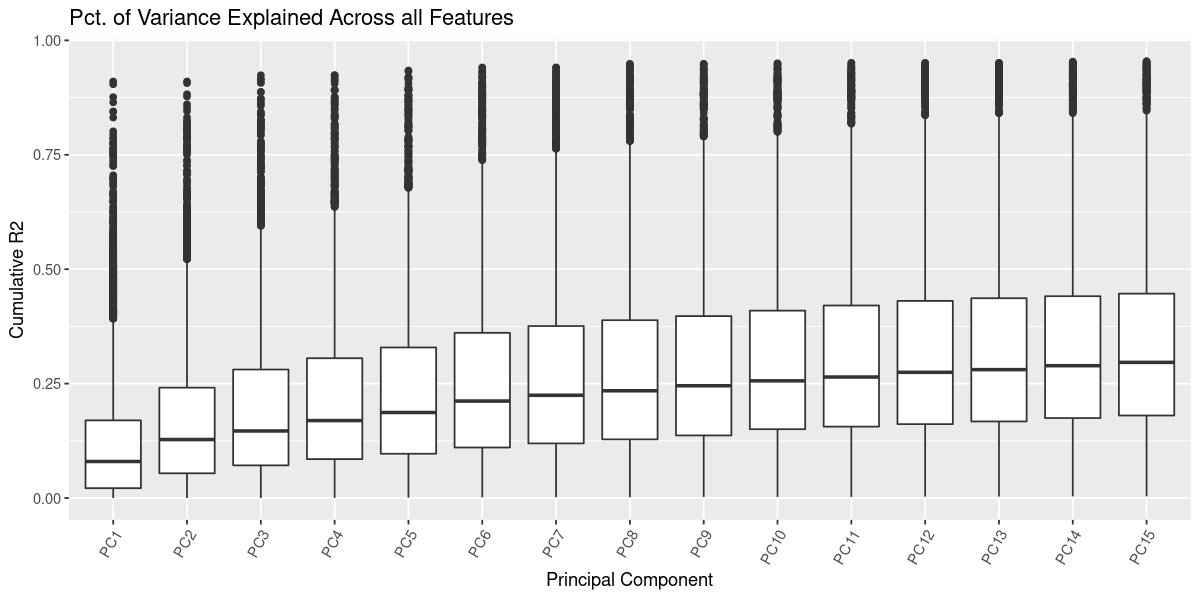

In [161]:
ggplot(data=scdf,mapping=aes(x=variable,y=value))+geom_boxplot()+
    labs(x="Principal Component",y="Cumulative R2")+
    theme(axis.text.x = element_text(angle = 60, vjust = 1, hjust=1))+
    ggtitle("Pct. of Variance Explained Across all Features")

So in this plot each point represents the median (cumul.) correlation (for that feature) between the wells and the PC. 